In [1]:
#%load_ext autoreload
%reload_ext autoreload
#%autoreload 2

%matplotlib notebook

import sys, time
import numpy as np
import math as m
import matplotlib.pyplot as plt
import extra_data as ex
import xarray as xr
import dask.array as da
from extra_data.components import AGIPD1M
from matplotlib.colors import LogNorm
import matplotlib as mpl
from extra_geom import AGIPD_1MGeometry
from scipy import ndimage
from scipy import signal
from tqdm import tqdm
from scipy.optimize import curve_fit

from extra_geom import LPD_1MGeometry
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

In [2]:
run = ex.open_run(proposal=900310, run=78)
#run.info()  # Show overview info about this data

from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster
partition = 'exfel'  # For EuXFEL staff
#partition = 'upex'   # For users

cluster = SLURMCluster(
    queue=partition,
    # Resources per SLURM job (per node, the way SLURM is configured on Maxwell)
    # processes=16 runs 16 Dask workers in a job, so each worker has 1 core & 16 GB RAM. silence_logs="debug",
    processes=5, cores=70, memory='600GB',nanny=True,death_timeout=100,walltime="24:00:00", job_name='run',
    local_directory = '/gpfs/exfel/exp/MID/201901/p002542/usr/Jo',log_directory = '/gpfs/exfel/exp/MID/201901/p002542/usr/Jo',
)

# Submit 2 SLURM jobs, for 32 Dask workers
cluster.scale(60)

client = Client(cluster)

# Get a notbook widget showing the cluster state
#cluster

# Loading AGIPD Data

In [3]:
# data address

cycle = 202231
proposal = 900310
run_no = 78



rundir_p = '/gpfs/exfel/exp/MID/{:06d}/p{:06d}/proc/r{:04d}'.format(cycle,proposal,run_no)
rundir_r = '/gpfs/exfel/exp/MID/{:06d}/p{:06d}/raw/r{:04d}'.format(cycle,proposal,run_no)

run_r = ex.RunDirectory(rundir_r)
run_p = ex.RunDirectory(rundir_p)

agp = AGIPD1M(run_p, min_modules=16)
arr = agp.get_dask_array("image.data")

arr = arr.unstack()

arr

<xarray.DataArray 'concatenate-263f2a182aa3f04202e9f0c49a044410' (module: 16, dim_0: 512, dim_1: 128, trainId: 7023, pulseId: 352)>
dask.array<reshape, shape=(16, 512, 128, 7023, 352), dtype=float32, chunksize=(1, 512, 128, 22, 352), chunktype=numpy.ndarray>
Coordinates:
  * module   (module) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * trainId  (trainId) uint64 1448454395 1448454396 ... 1448461922 1448461923
  * pulseId  (pulseId) uint64 0 2 4 6 8 10 12 14 ... 690 692 694 696 698 700 702
Dimensions without coordinates: dim_0, dim_1

# Inspect Lotz 

<IPython.core.display.Javascript object>


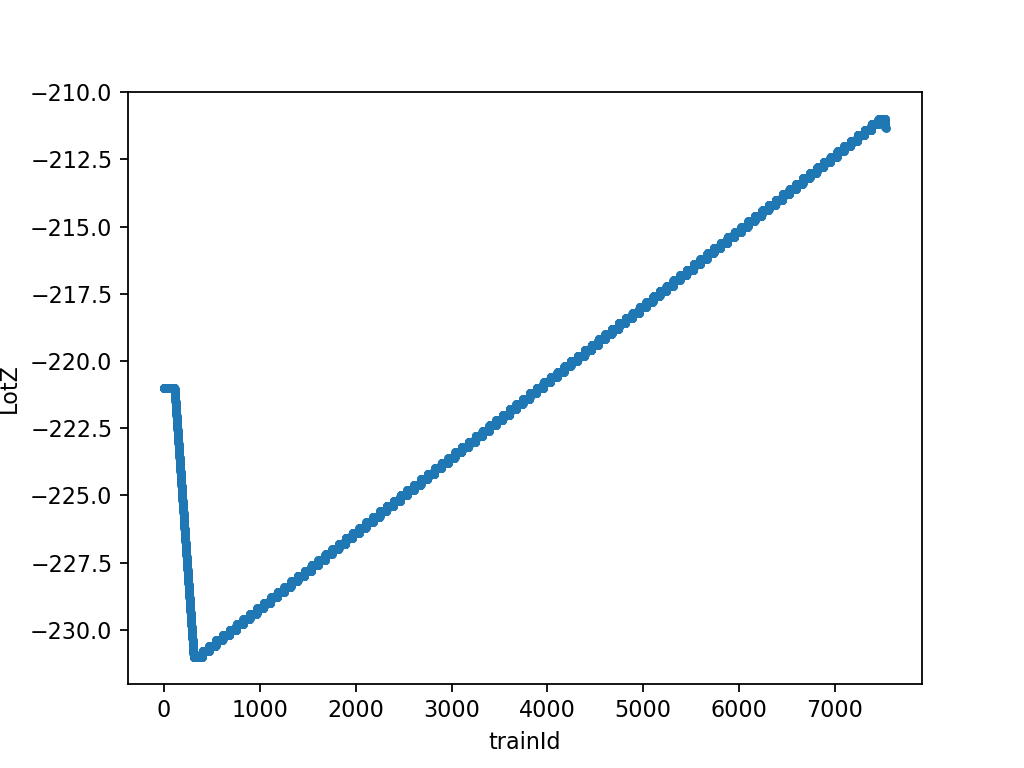

Text(0, 0.5, 'LotZ')

In [4]:
source = 'MID_EXP_SAM/MOTOR/LOTZ'
sub_source = 'actualPosition.value'
arr_Lotz = run_r.get_dask_array(source, sub_source, labelled=True)

plt.figure()
plt.plot(arr_Lotz,'.')
plt.xlabel('trainId')
plt.ylabel('LotZ')

In [77]:
lotz = []
for i in tqdm(range(Ntrains)):
    t = arr_Lotz.values[trainIDs[i]]
    lotz.append(t)

100%|██████████| 30/30 [00:02<00:00, 10.22it/s]


## AGIPD quadrant positions

In [5]:
#load positions of AGIPD quadrants
def load_AGIPD_Motors(run):
    motVal=[]
    for name in ( ['q1m1','q2m1','q3m1','q4m1','q1m2','q2m2','q3m2','q4m2']):
        prop = f'{name}ActualPosition'
        arr = run['MID_AGIPD_MOTION/MDL/DOWNSAMPLER',prop].xarray().data[0]
        motVal.append(arr)
    return motVal


q1m1, q2m1, q3m1, q4m1, q1m2, q2m2, q3m2, q4m2 = load_AGIPD_Motors(run_r)

q1_x = -542 + 0*q1m1
q1_y = 660 + q1m1/(-0.2)
q2_x = -608 + 0*q2m1
q2_y = -35 + q2m1/0.2
q3_x = 534 + 0*q3m1
q3_y = -221 + q3m1/0.2
q4_x = 588 + 0*q4m1
q4_y = 474 + q4m1/(-0.2)    
quad_pos = [(q1_x, q1_y),
               (q2_x, q2_y),
               (q3_x, q3_y),
               (q4_x, q4_y)]  

geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=quad_pos)
g = geom.get_pixel_positions()

# Conditions

In [6]:
Ntrains = 30
Npulse = 4

#pulseIDs = np.linspace(14,24,Npulse, dtype=int)
trainIDs = np.linspace(390,7000,Ntrains, dtype=int)


In [7]:
trainIDs

array([ 390,  617,  845, 1073, 1301, 1529, 1757, 1985, 2213, 2441, 2669,
       2897, 3125, 3353, 3581, 3808, 4036, 4264, 4492, 4720, 4948, 5176,
       5404, 5632, 5860, 6088, 6316, 6544, 6772, 7000])

In [8]:
pulseIDs = [3, 7, 20, 25]

In [311]:
single_img = arr.isel(pulseId = 3, trainId = 2593)

geom.plot_data_fast(single_img, figsize=(9, 9),norm = LogNorm(vmin = 1e-1, vmax = 1e2))
plt.title('single shot image in photon*keV')

KeyboardInterrupt: 

# Selecting ROI

In [9]:
s = 60


roi = []

for i in tqdm(range(Ntrains)):
    roi_temp = []
    for j in range(Npulse):
        module = arr.isel(module = 3, pulseId = pulseIDs[j], trainId = trainIDs[i]) 
        roi_temp.append(ndimage.rotate(module[-s:,-s:], 270))
    roi.append(roi_temp)

100%|██████████| 30/30 [03:53<00:00,  7.77s/it]


## Selecting best from 3 pulses 

In [10]:
roi_new = []
for i in range(Ntrains):
    roi_new.append(roi[i][0])

<IPython.core.display.Javascript object>


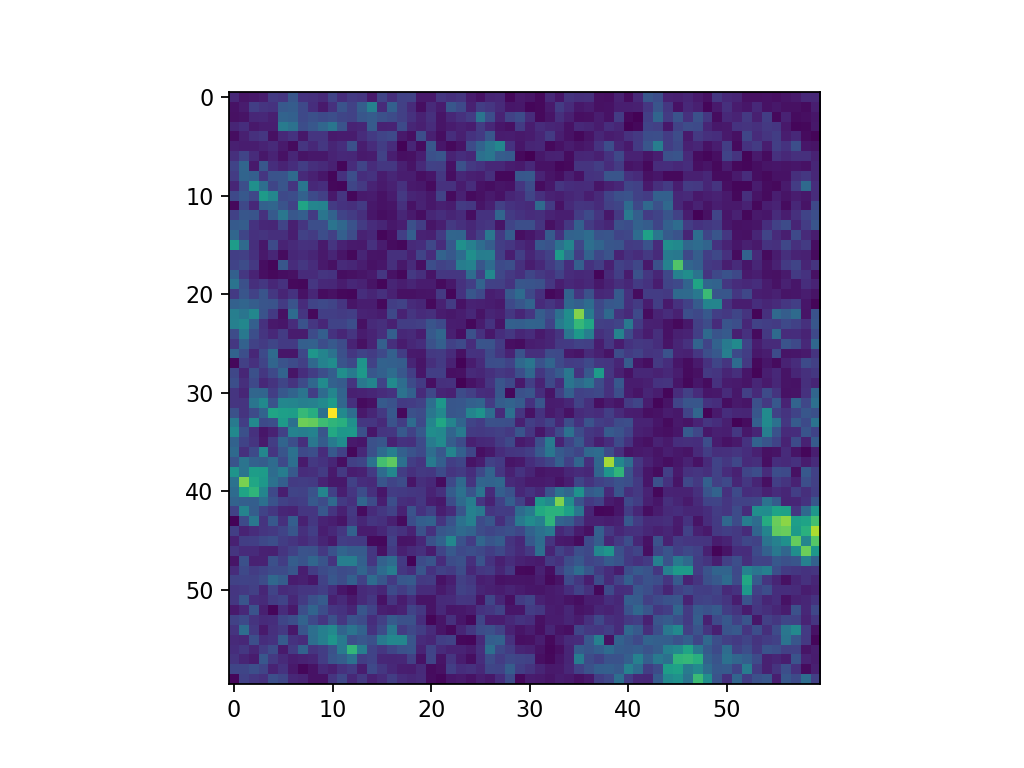

<IPython.core.display.Javascript object>


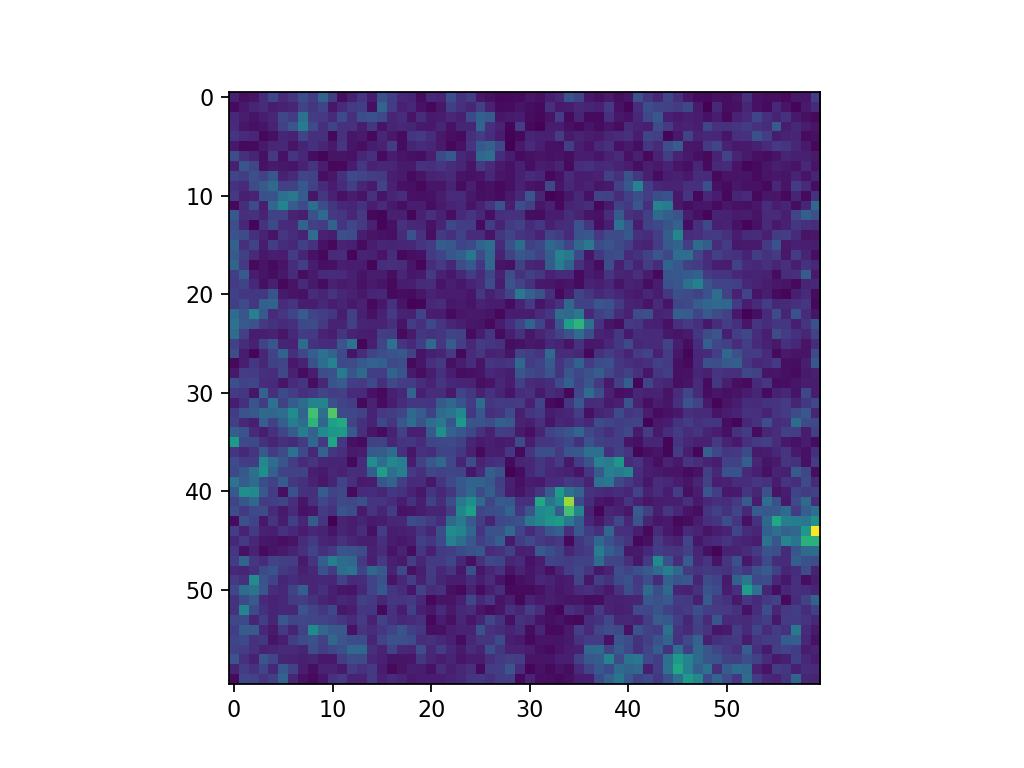

<IPython.core.display.Javascript object>


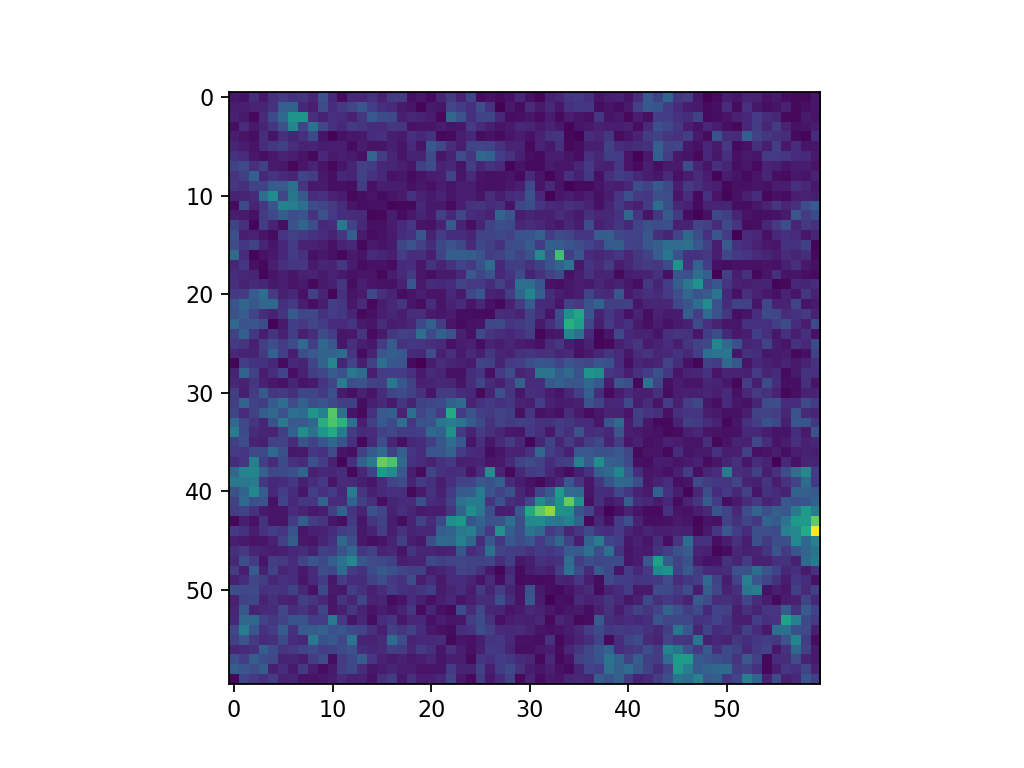

<IPython.core.display.Javascript object>


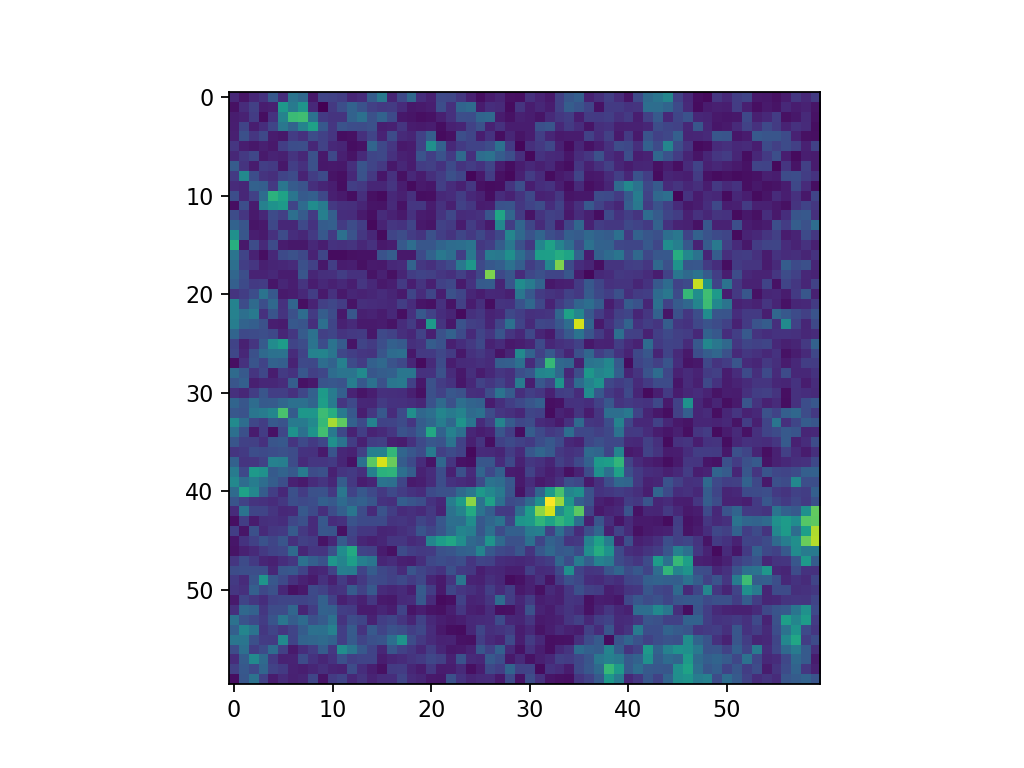

In [59]:
for i in range(4):
    plt.figure()
    t = 11
    plt.imshow(roi[t][i])

In [60]:
roi_new[t] = roi[t][3]

<IPython.core.display.Javascript object>


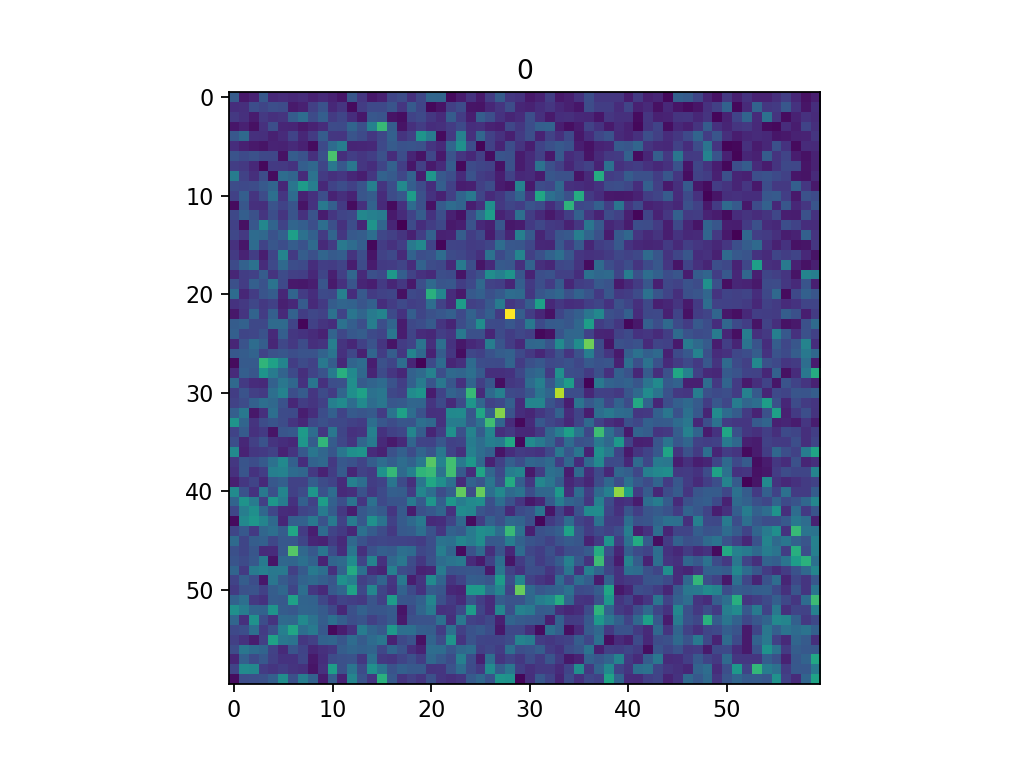

<IPython.core.display.Javascript object>


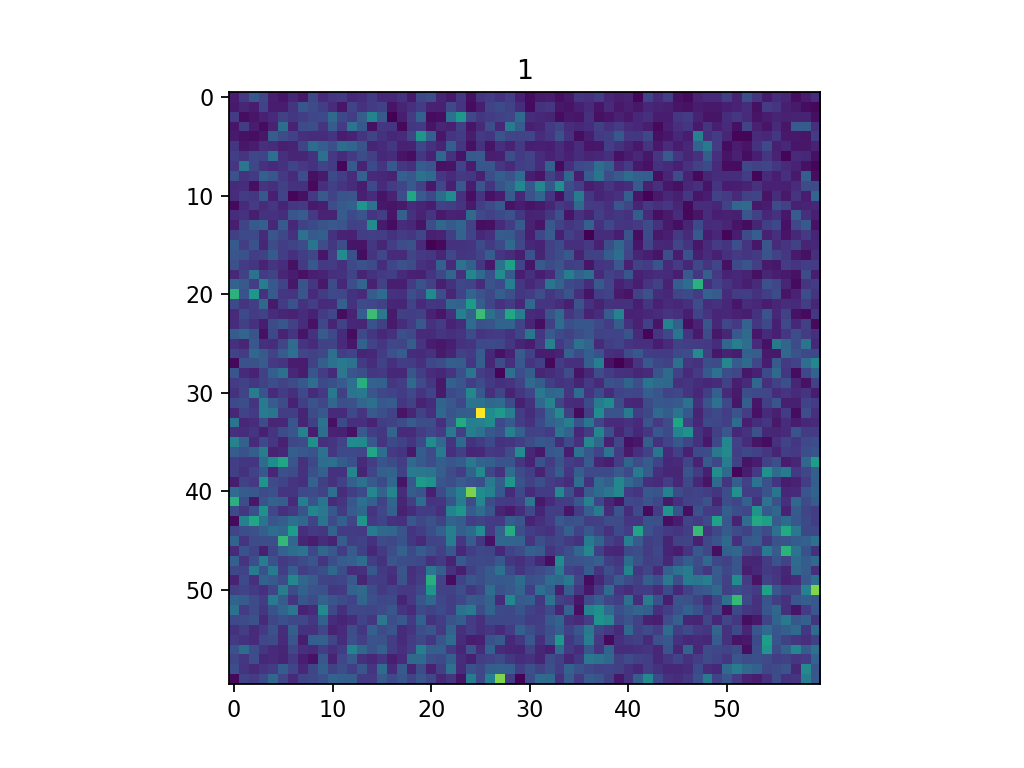

<IPython.core.display.Javascript object>


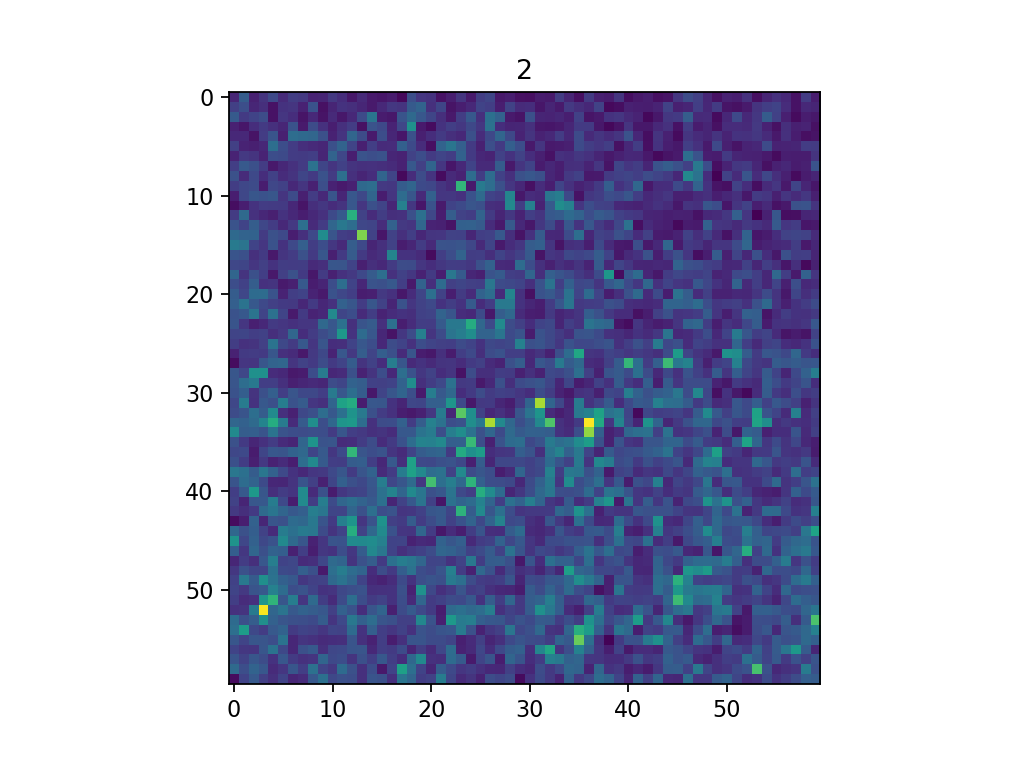

<IPython.core.display.Javascript object>


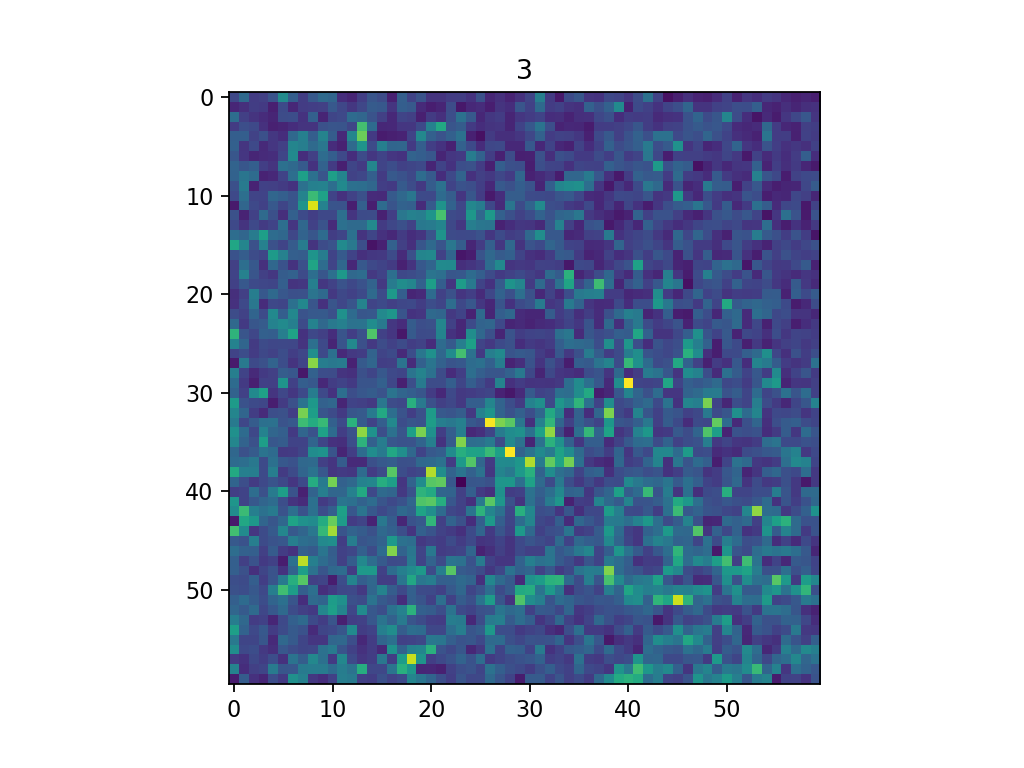

<IPython.core.display.Javascript object>


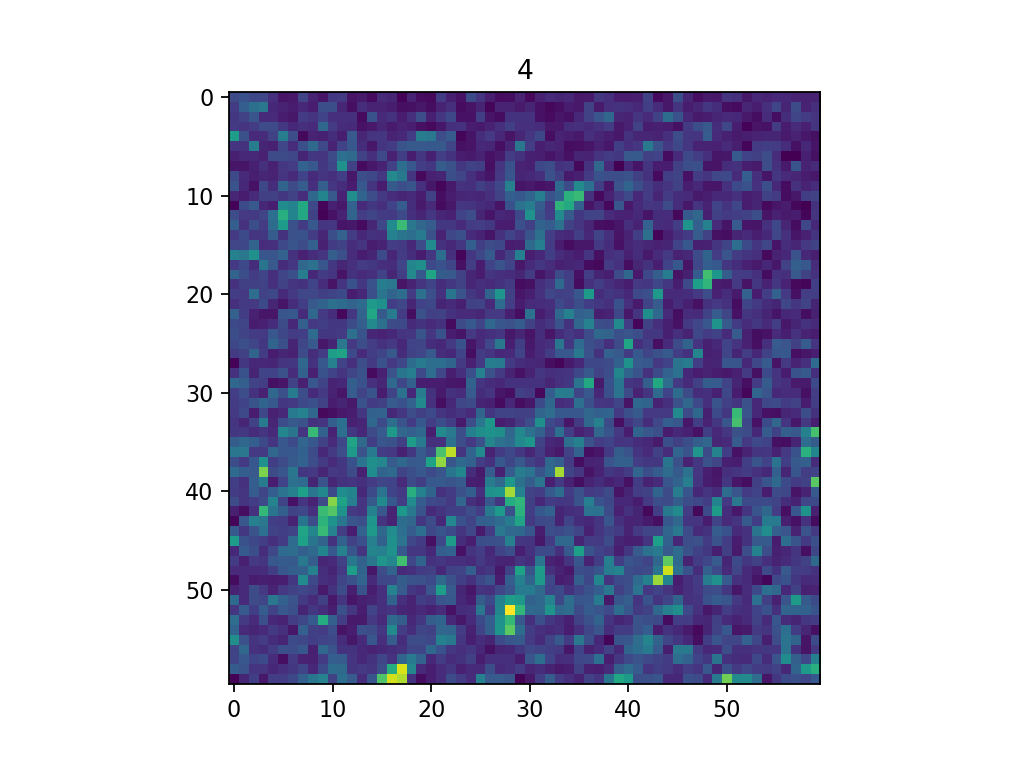

<IPython.core.display.Javascript object>


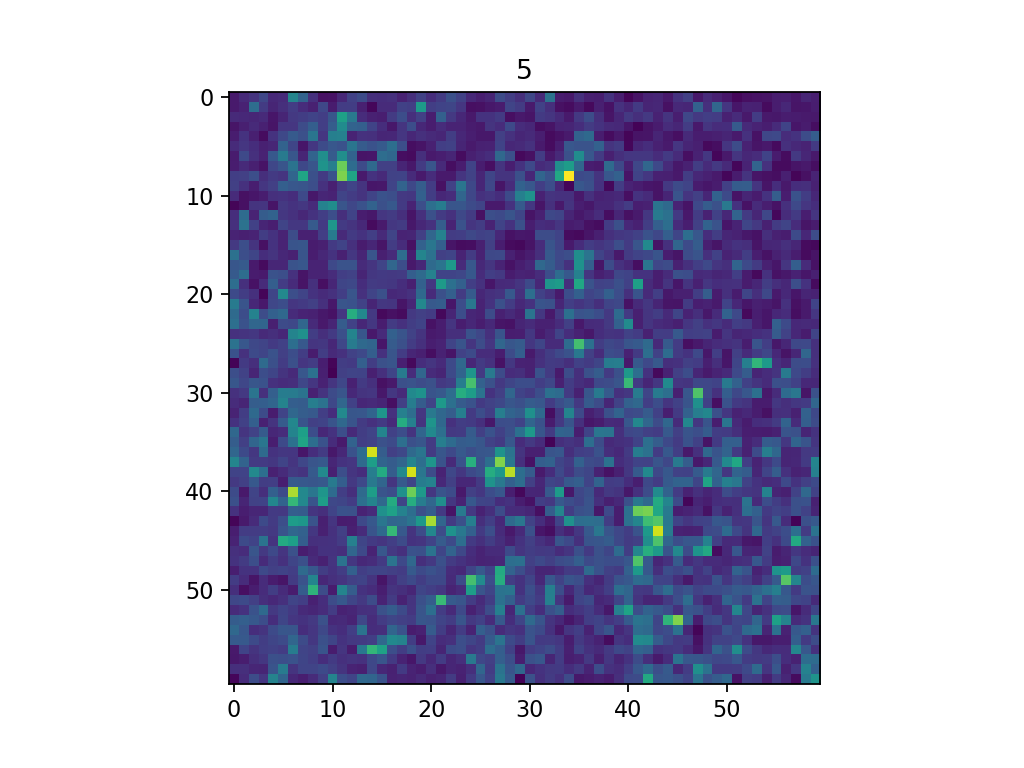

<IPython.core.display.Javascript object>


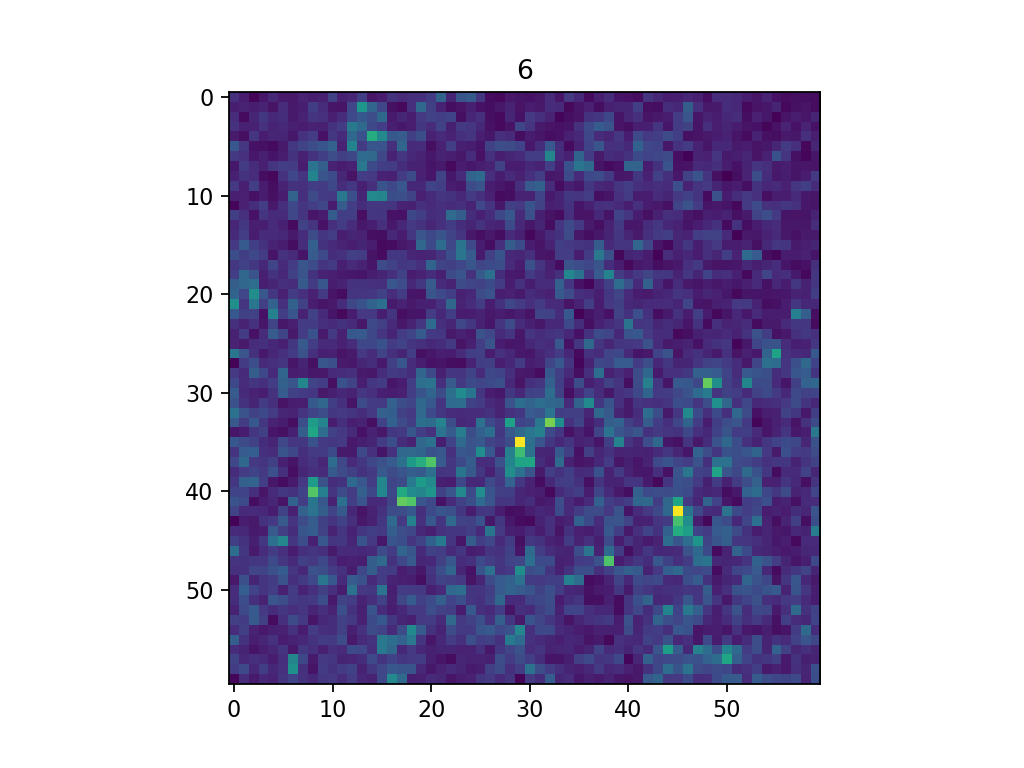

<IPython.core.display.Javascript object>


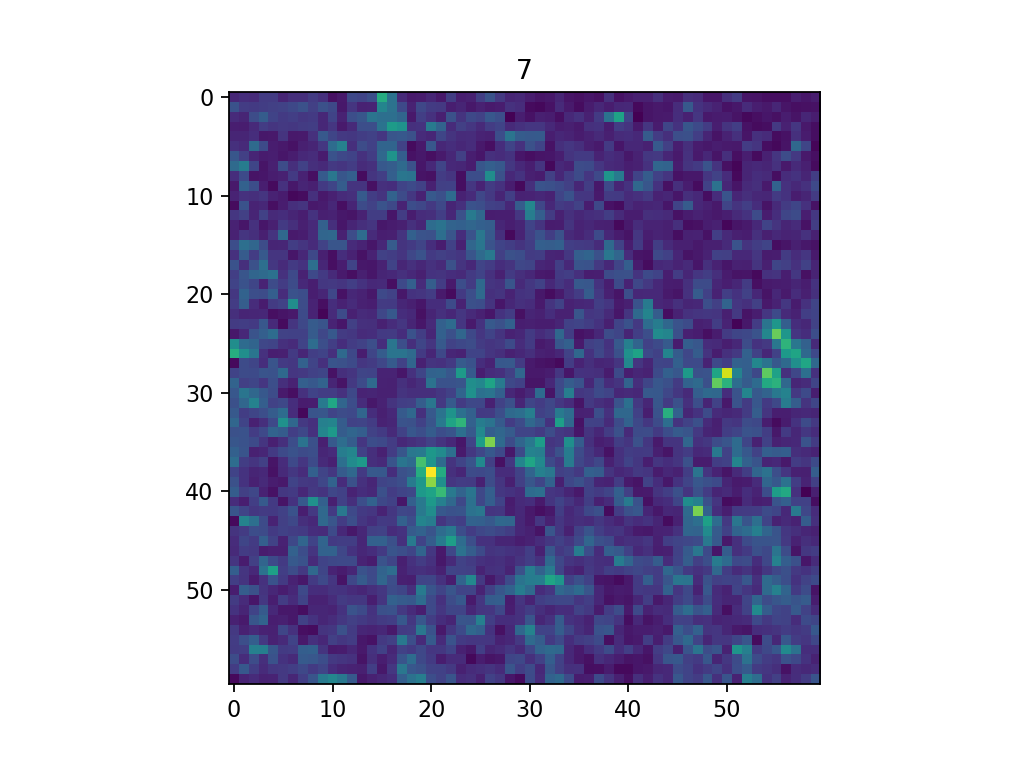

<IPython.core.display.Javascript object>


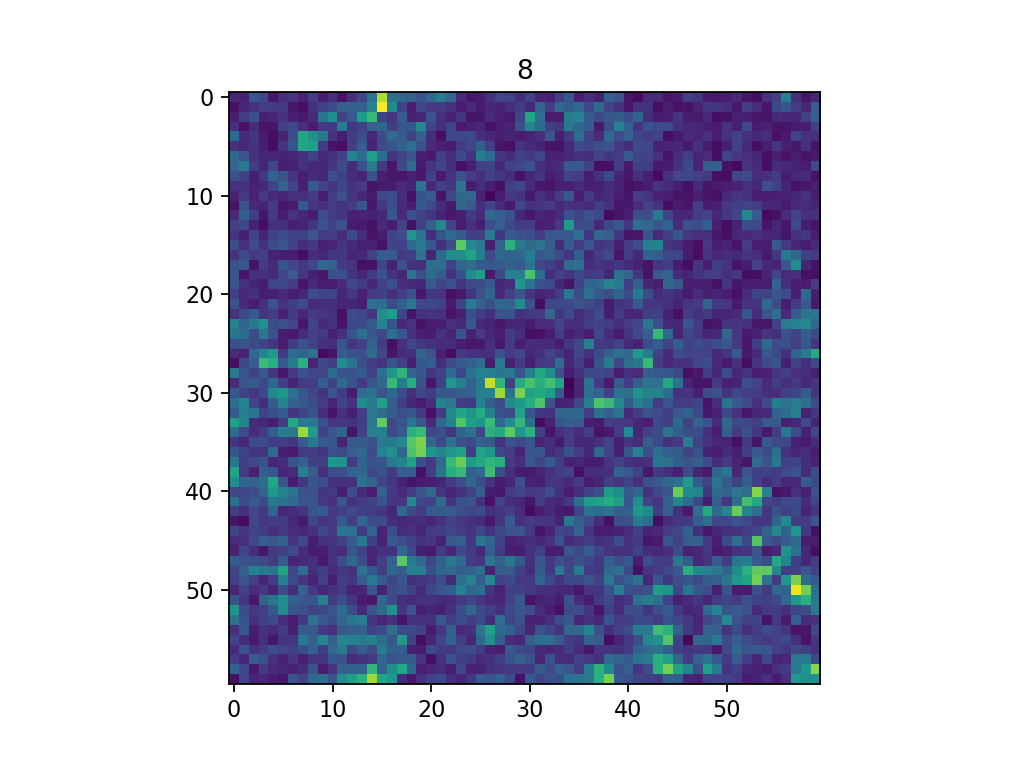

<IPython.core.display.Javascript object>


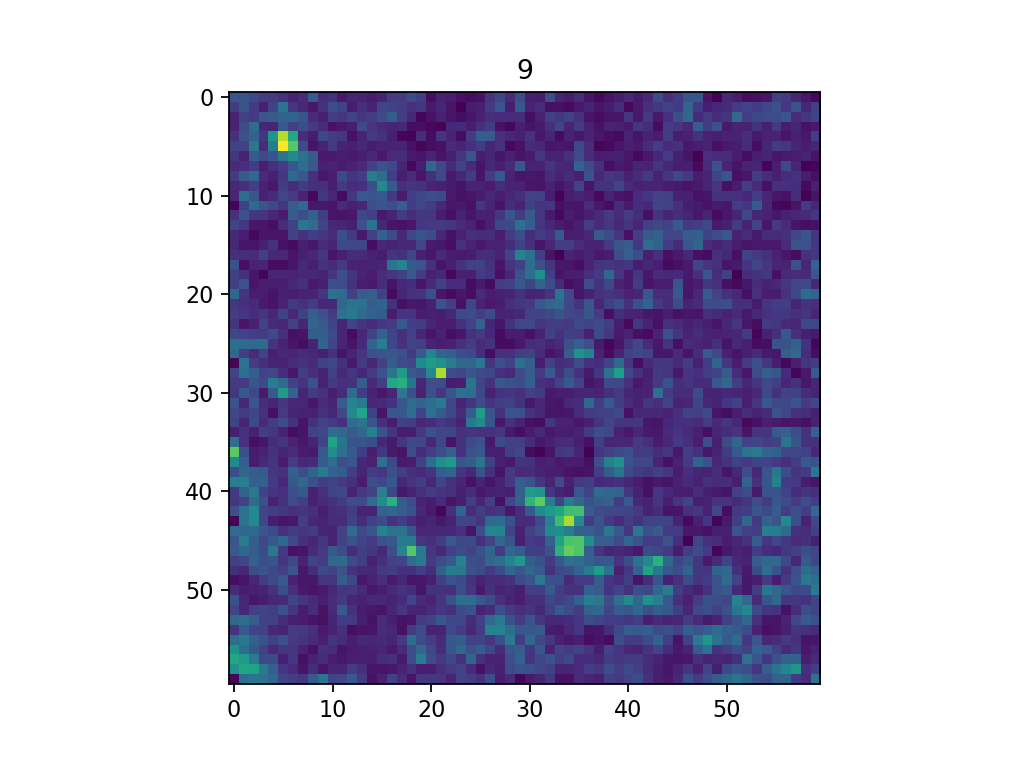

<IPython.core.display.Javascript object>


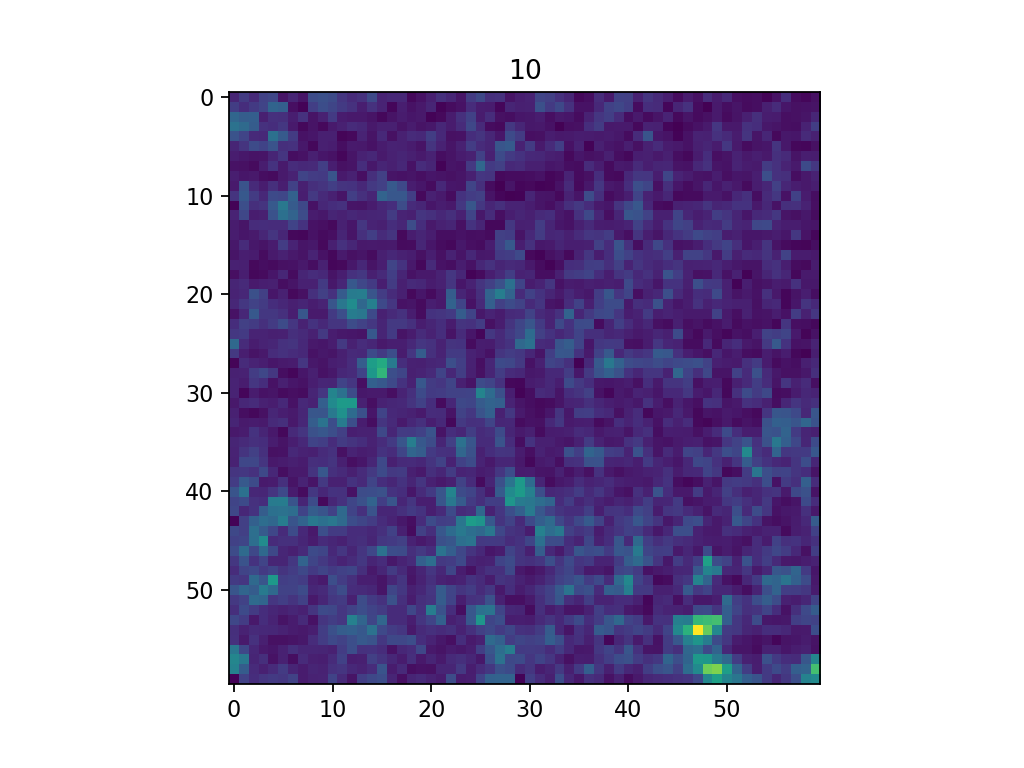

<IPython.core.display.Javascript object>


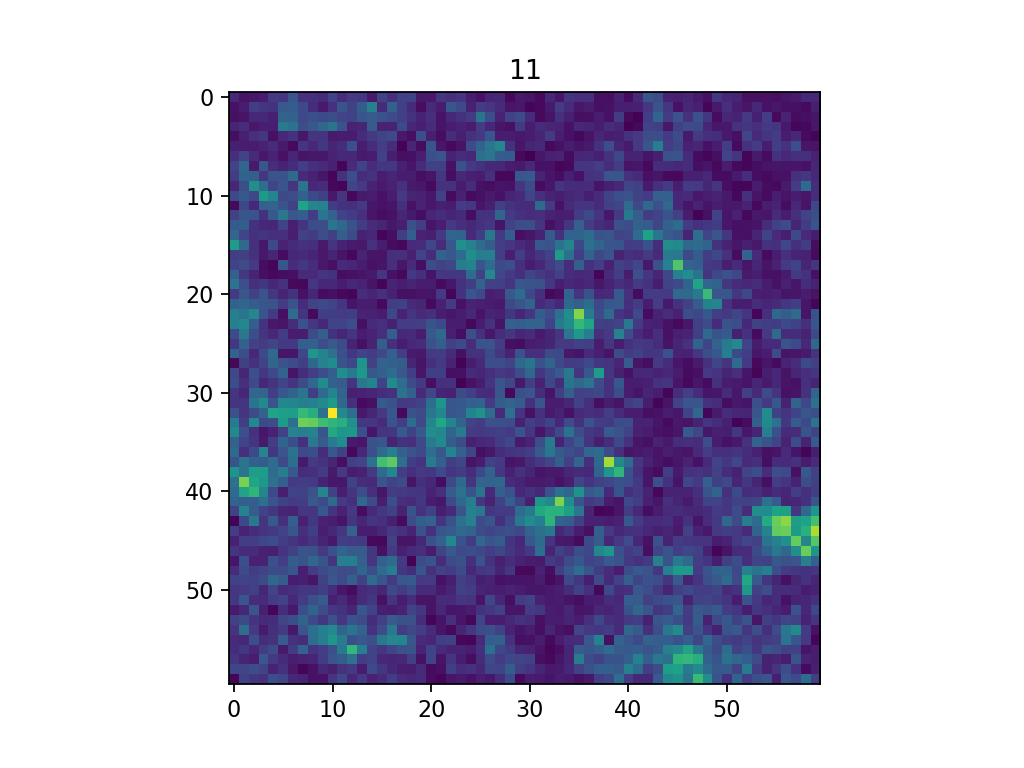

<IPython.core.display.Javascript object>


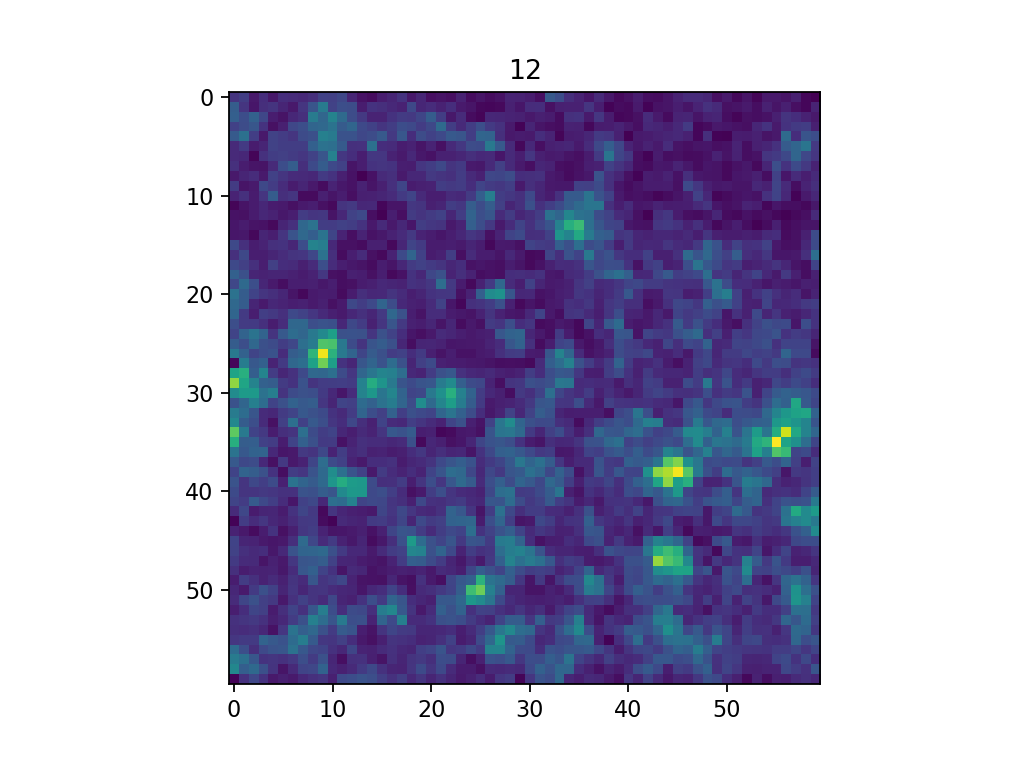

<IPython.core.display.Javascript object>


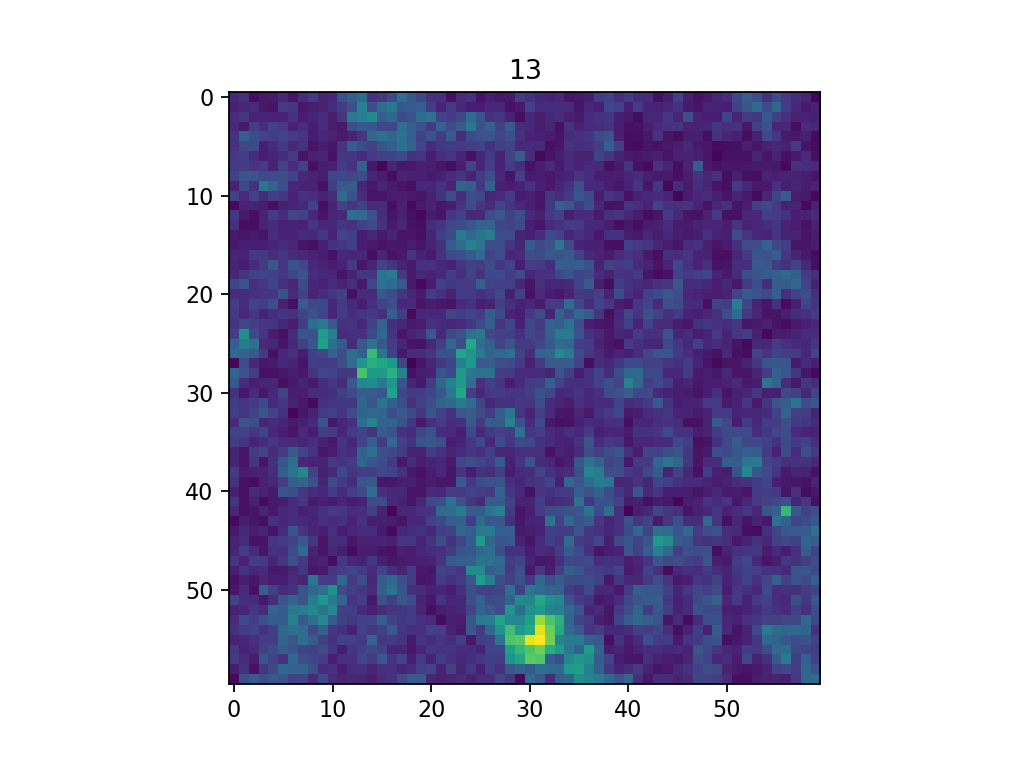

<IPython.core.display.Javascript object>


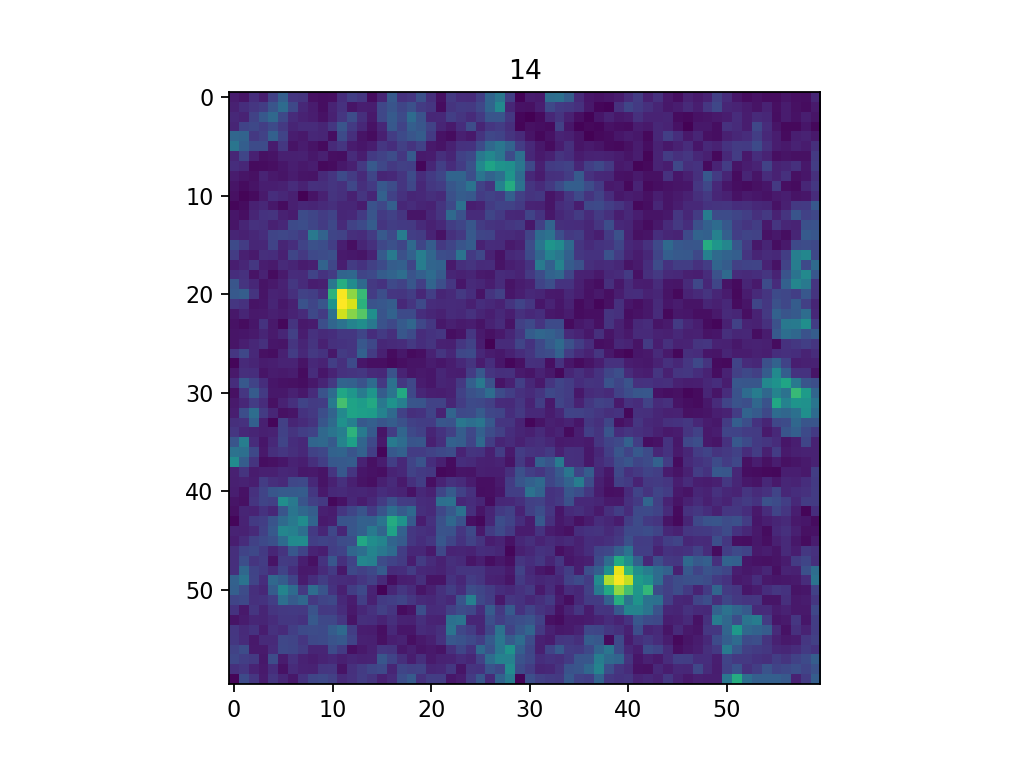

<IPython.core.display.Javascript object>


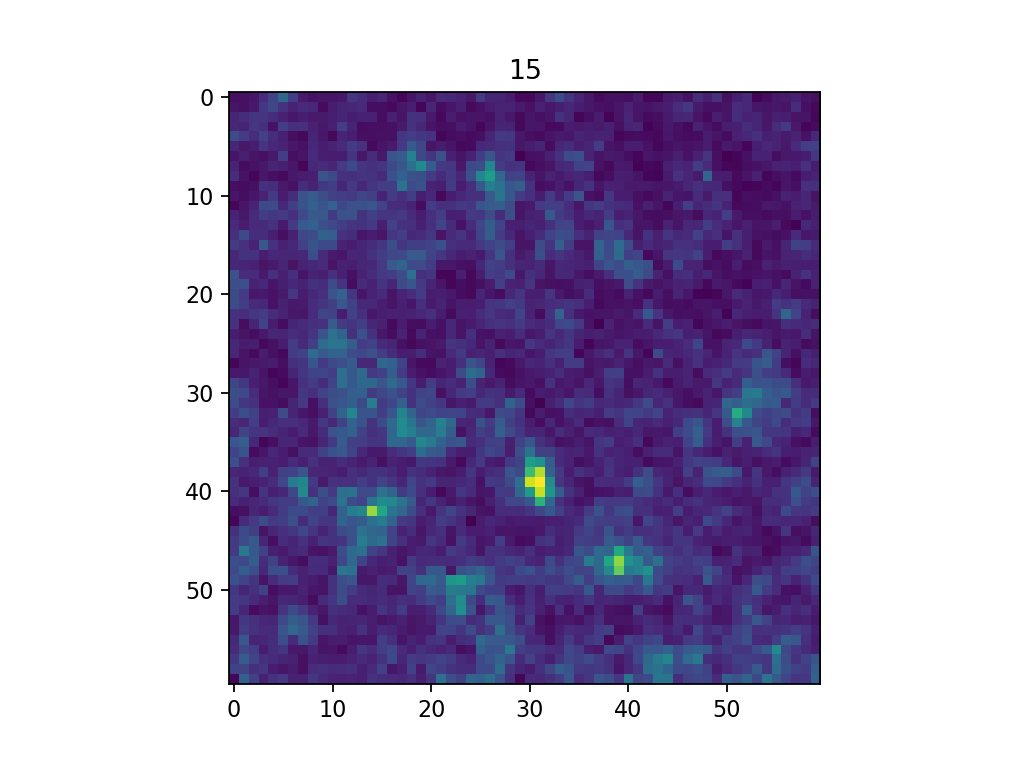

<IPython.core.display.Javascript object>


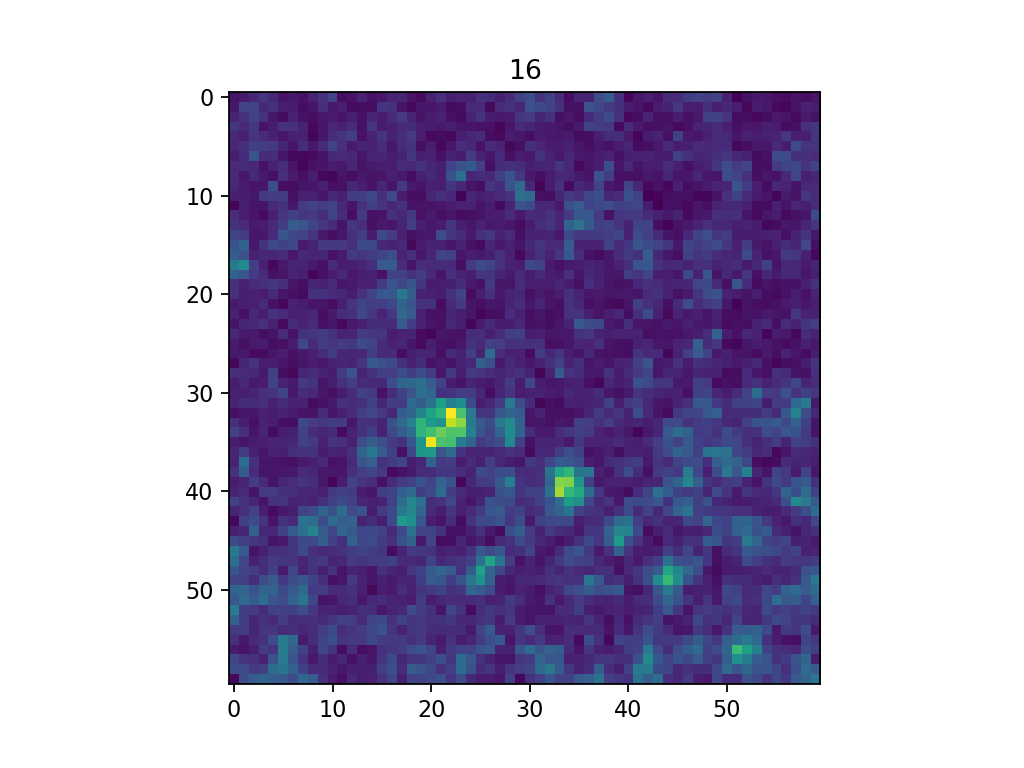

<IPython.core.display.Javascript object>


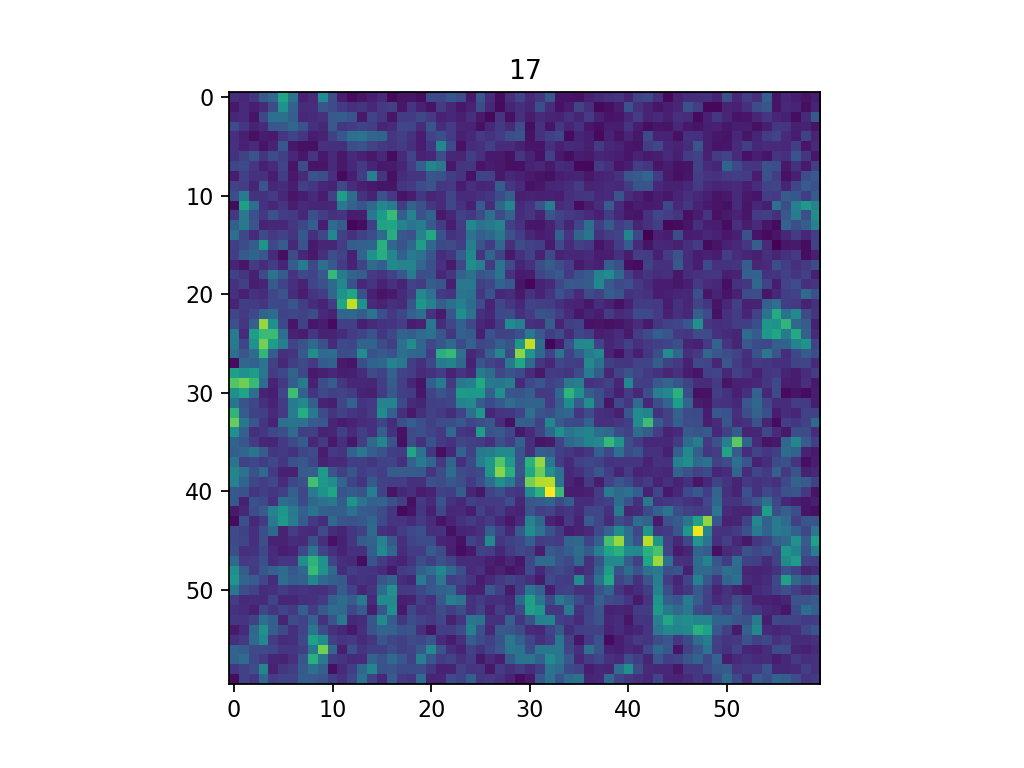

<IPython.core.display.Javascript object>


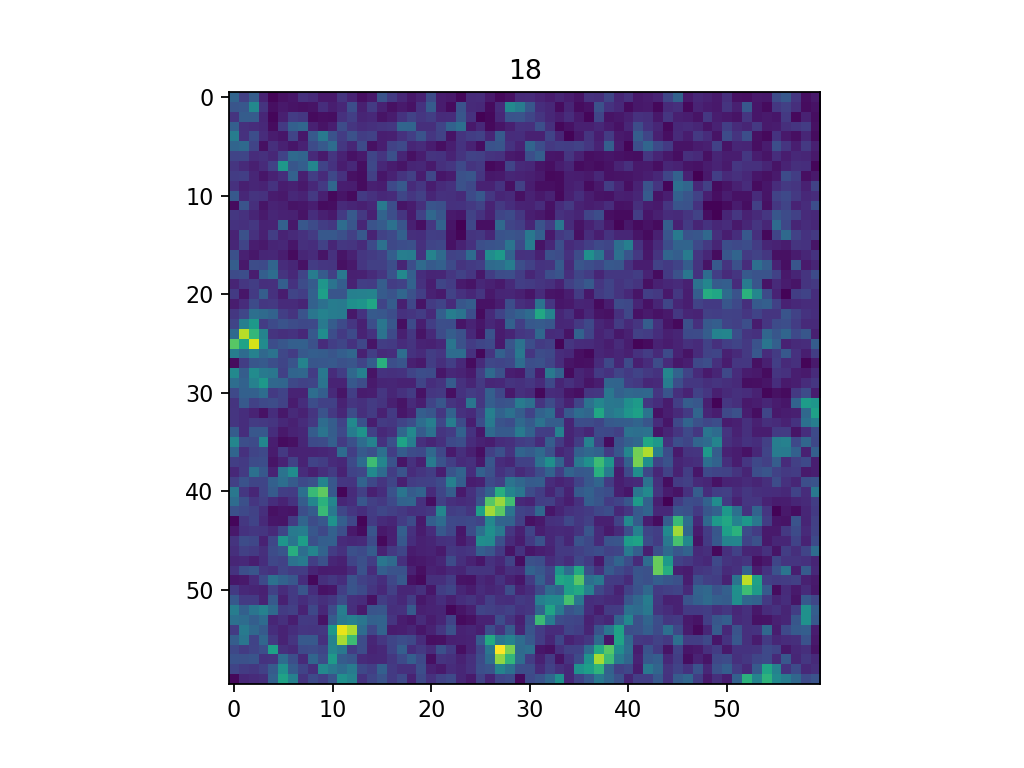

<IPython.core.display.Javascript object>


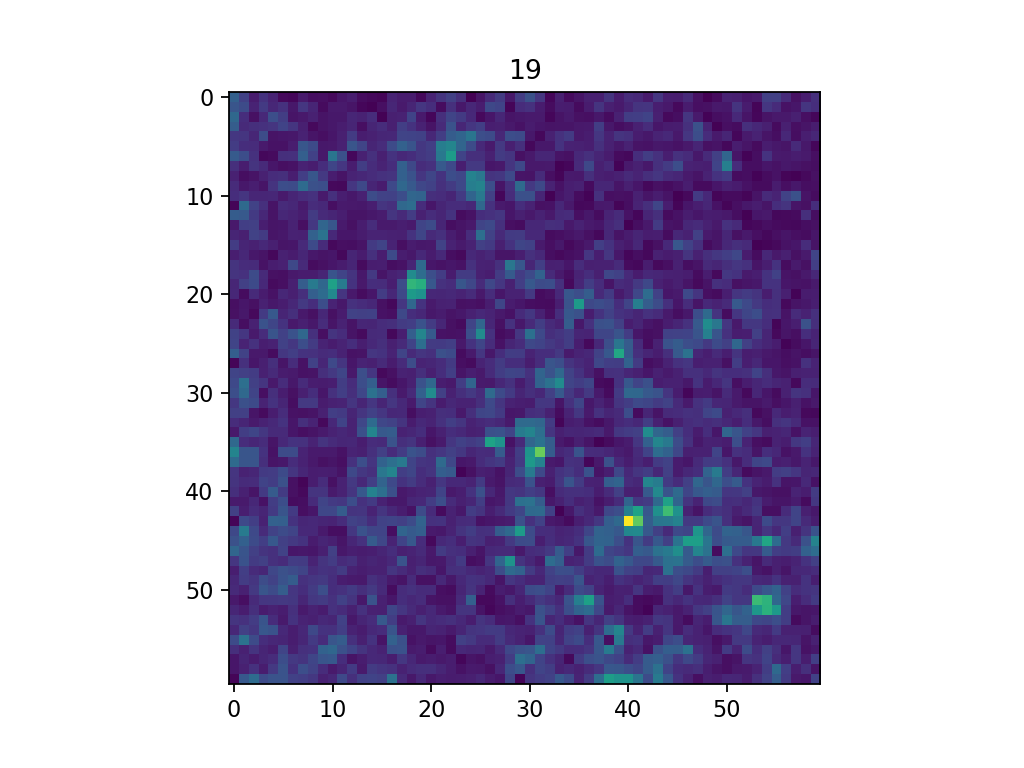

<IPython.core.display.Javascript object>


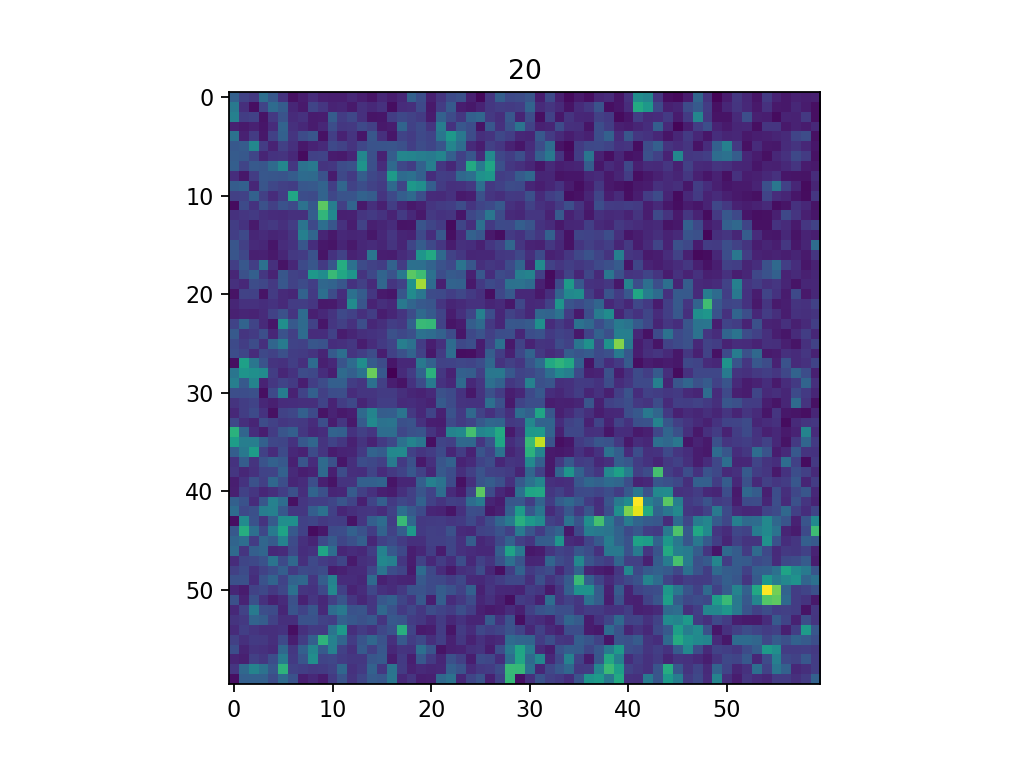

<IPython.core.display.Javascript object>


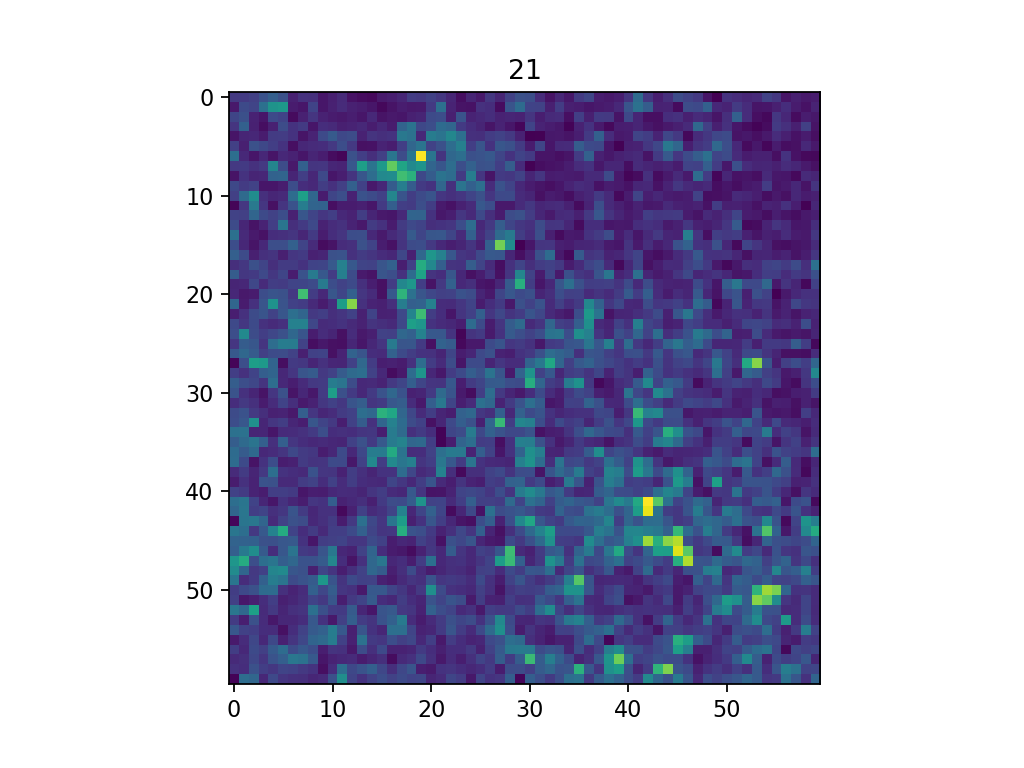

<IPython.core.display.Javascript object>


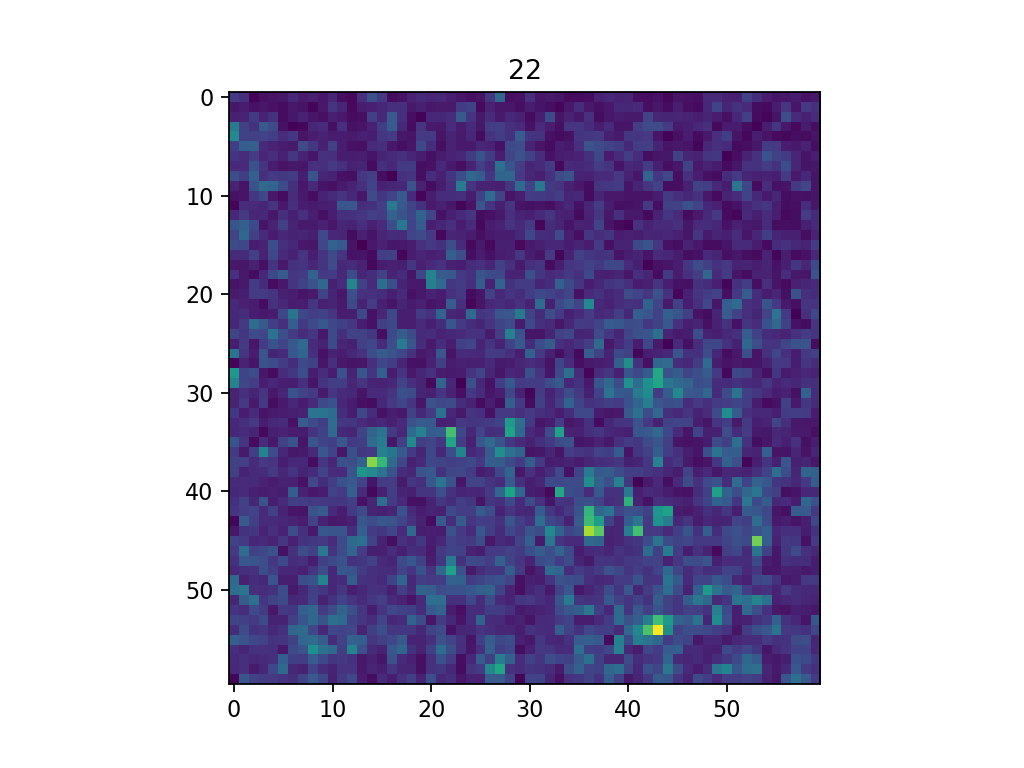

<IPython.core.display.Javascript object>


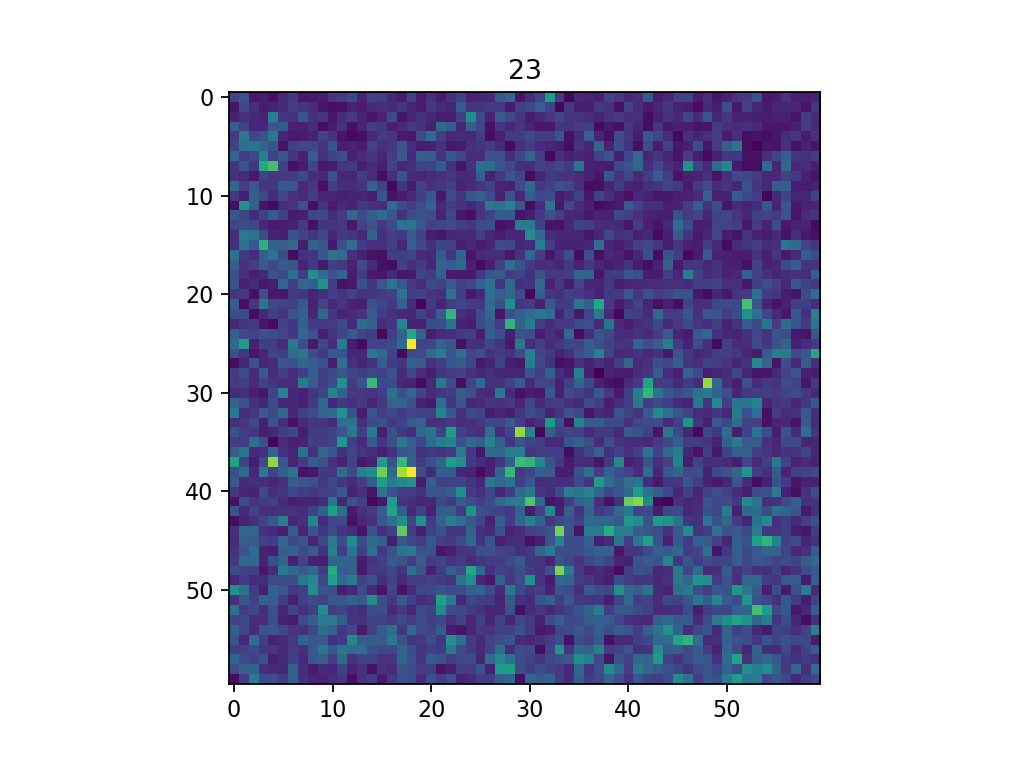

<IPython.core.display.Javascript object>


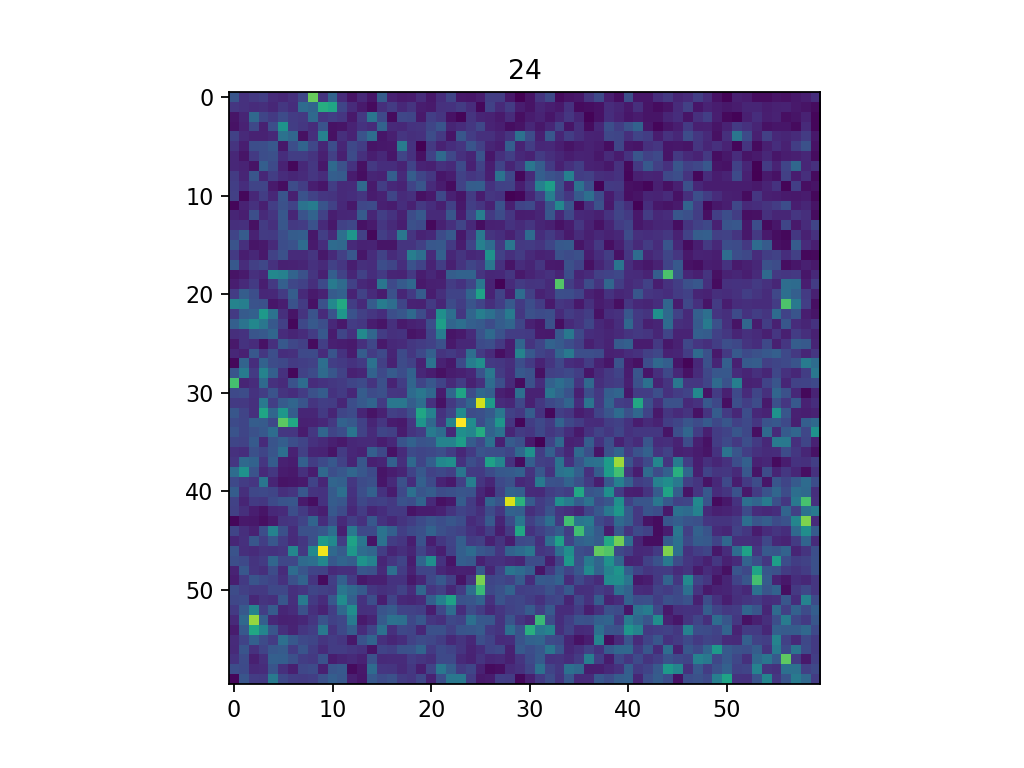

<IPython.core.display.Javascript object>


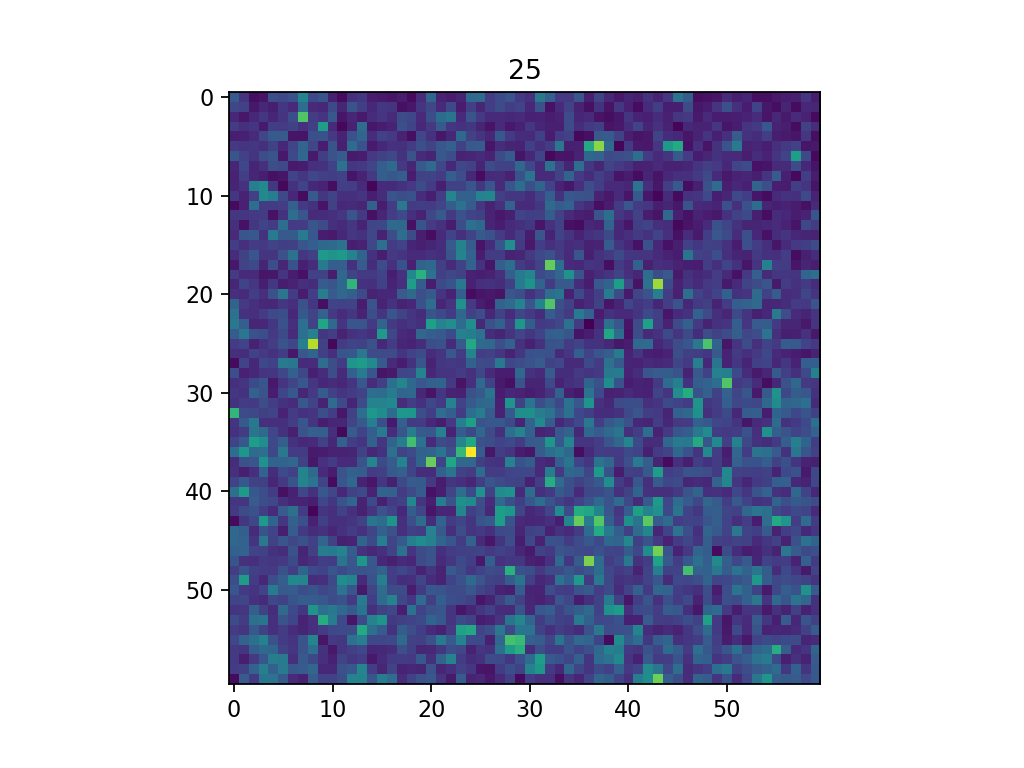

<IPython.core.display.Javascript object>


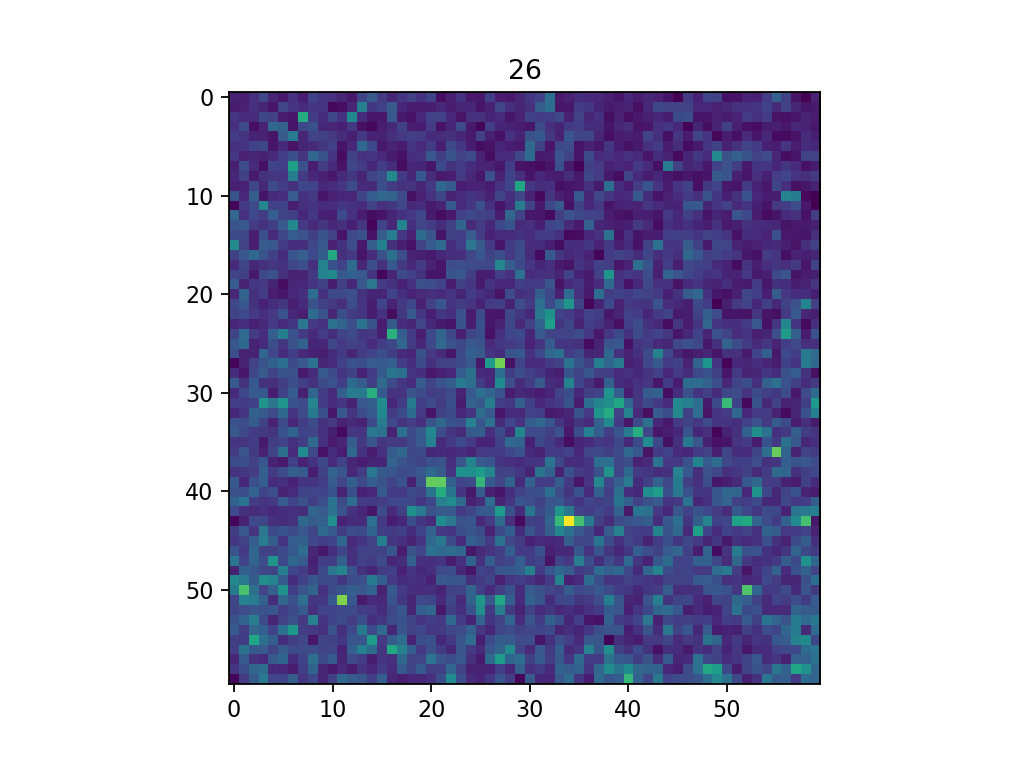

<IPython.core.display.Javascript object>


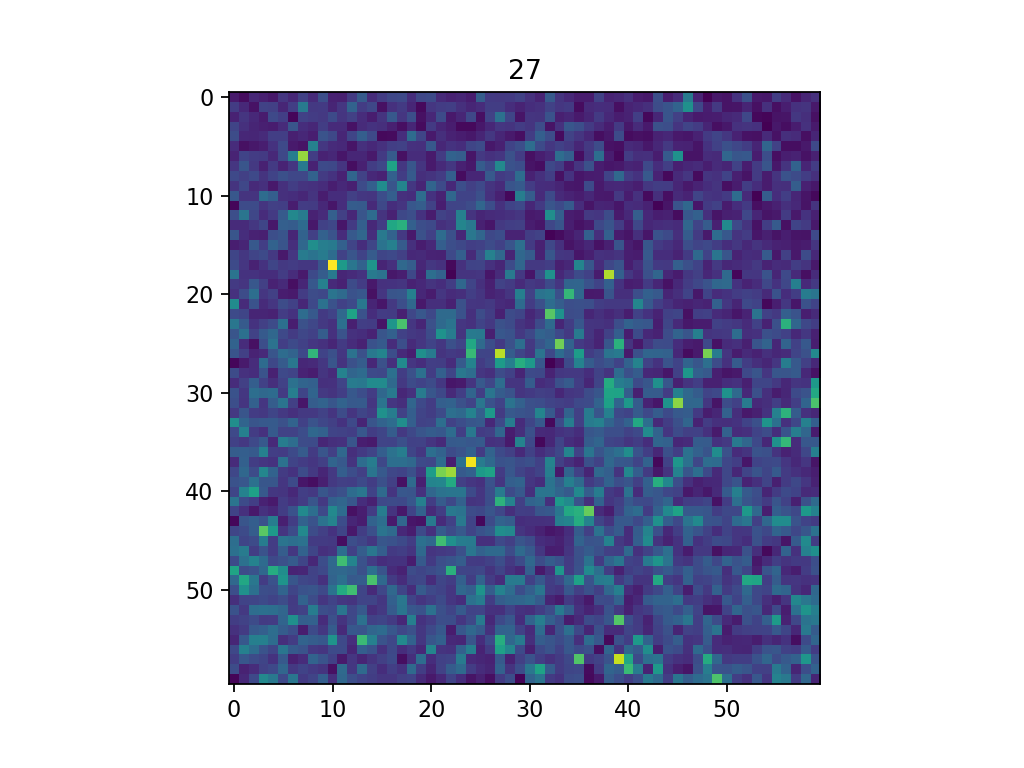

<IPython.core.display.Javascript object>


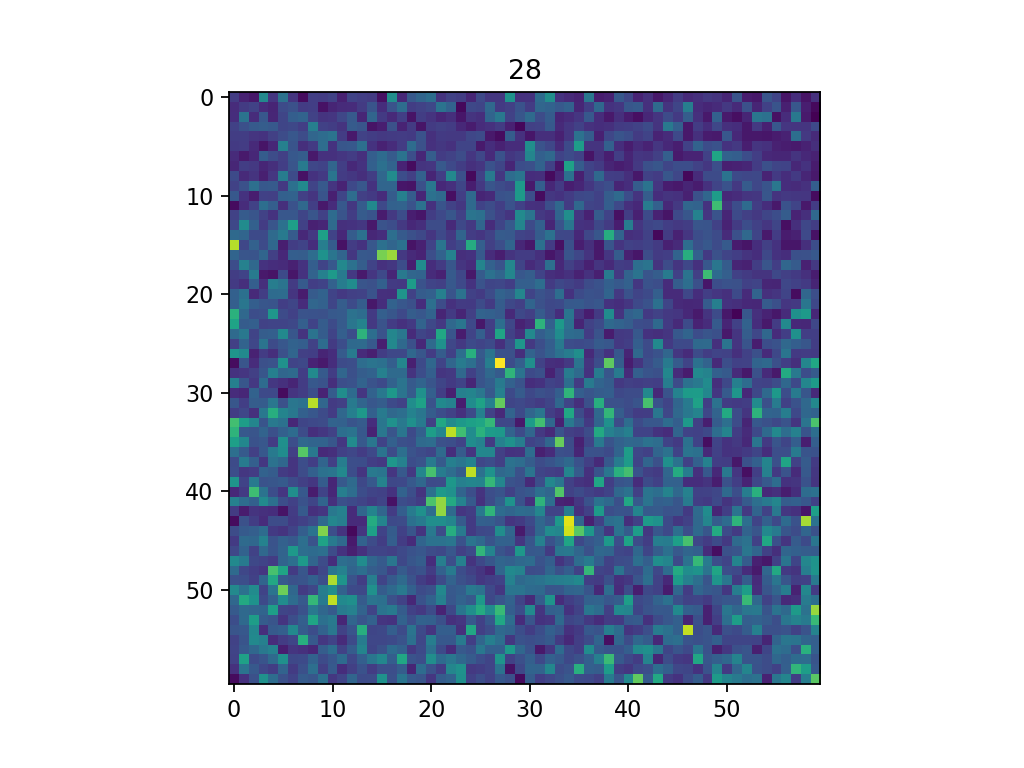

<IPython.core.display.Javascript object>


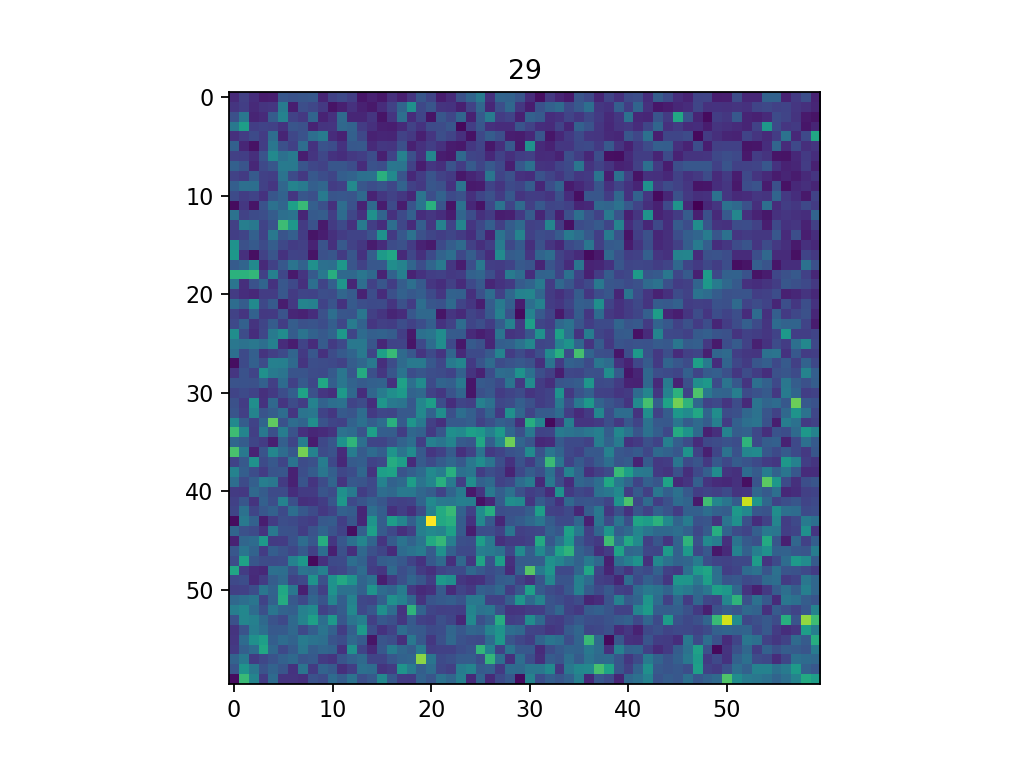

In [35]:
for i in range(Ntrains):
    plt.figure()
    plt.imshow(roi_new[i])
    plt.title(i)

In [61]:
for i in range(Ntrains):
    roi[i][0] = roi_new[i]

In [62]:
# performing the autocorrelation

corr_pulses = []  # has shape (len(arr), len(pulses))
avg_corr = []

# getting C(I)
for i in tqdm(range(len(roi))):
    corr_temp = []
    for j in range(len(roi[i])):
        # saving the correlation matricies
        corr = signal.correlate2d(roi[i][j], roi[i][j], mode='full', boundary='fill', fillvalue=0)
        corr_temp.append(corr)
    corr_pulses.append(corr_temp)
    
# getting 1D functions
index = int(np.argmax(corr_pulses[0][0][int(len(corr_pulses[0][0])/2)]))

od_corr_pulses = []

for i in range(len(corr_pulses)):
    grouping_array = []
    for j in range(len(corr_pulses[0])):
        image = corr_pulses[i][j]
        ycut = image[index,:]
        grouping_array.append(ycut)
    od_corr_pulses.append(grouping_array)


100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


In [63]:
# getting the <C(I)>
for i in tqdm(range(len(corr_pulses))):
    for j in range(len(corr_pulses[0])):                      #these two lines could be
        corr_pulses[i][j] = np.matrix(corr_pulses[i][j])      #totally unnecessary
    corr_pulses[i] = np.array(corr_pulses[i])
    average = np.mean(corr_pulses[i], axis=0)
    avg_corr.append(average)    

# 1D of <C(I)>
od_avg_corr = []

for image in avg_corr:
    ycut = image[index,:]
    od_avg_corr.append(ycut)


100%|██████████| 30/30 [00:00<00:00, 1638.91it/s]


In [64]:
# 1D of C(I)
od_corr = []
for i in tqdm(range(len(corr_pulses))):
    tt = []
    for j in range(len(corr_pulses[0])):      
        temp = corr_pulses[i][j][index,:]
        tt.append(temp)
    od_corr.append(tt)

100%|██████████| 30/30 [00:00<00:00, 137218.23it/s]


## C(< I >)

In [40]:
# Average I over multiple pulses

avg_I = []
for i in tqdm(range(len(trainIDs))):
    mean = arr.isel(module = 3, pulseId = slice(0,500),trainId = slice(trainIDs[i])).mean(['pulseId','trainId']).compute()
    average_t = ndimage.rotate(mean[-s:,-s:], 270)
    avg_I.append(average_t)
    

100%|██████████| 30/30 [00:02<00:00, 11.20it/s]


In [65]:
# correlating the averaged image C(<I>)
corr_avg_I = []
for i in tqdm(range(len(avg_I))):
    corr = signal.correlate2d(avg_I[i], avg_I[i], mode='full', boundary='fill', fillvalue=0)
    corr_avg_I.append(corr)
    
# 1D of C(<I>)
od_corr_avg_I = []

for image in corr_avg_I:
    ycut = image[index,:]
    od_corr_avg_I.append(ycut)

100%|██████████| 30/30 [00:02<00:00, 11.35it/s]


## bkg subtraction + normalisation

In [66]:
#rescale intensities


#define function that gives a scaling factor that will remove background intensity from the correlation function
def func(y, scale):
    return scale*y

n_od_corr = []

for i in range(len(od_corr)):
    temp = []
    for j in range(len(od_corr[0])):
        # a - b // <gi> - g<i>
        a = od_corr[i][j]
        b = od_corr_avg_I[i]
        p, c = curve_fit(func, od_corr_avg_I[i], od_corr[i][j], p0=0.01)
        scale = 1/p
        temp.append(scale*a)
    n_od_corr.append(temp)
        

In [67]:
#Index of pulse to inspect.
Index = 0

#subtracting background from all individual 1d correlation function
subtracted_ycut = []
for i in range(len(od_corr_avg_I)):
    x = n_od_corr[i][Index] - od_corr_avg_I[i]
    subtracted_ycut.append(x)

subtracted_ycut_normalised = []
for i in range(len(subtracted_ycut)):
    x = subtracted_ycut[i]/int(max(subtracted_ycut[i]))
    subtracted_ycut_normalised.append(x)

In [44]:
xaxis = np.linspace(- len(subtracted_ycut[0])/2, len(subtracted_ycut[0])/2, len(subtracted_ycut[0]))

<IPython.core.display.Javascript object>


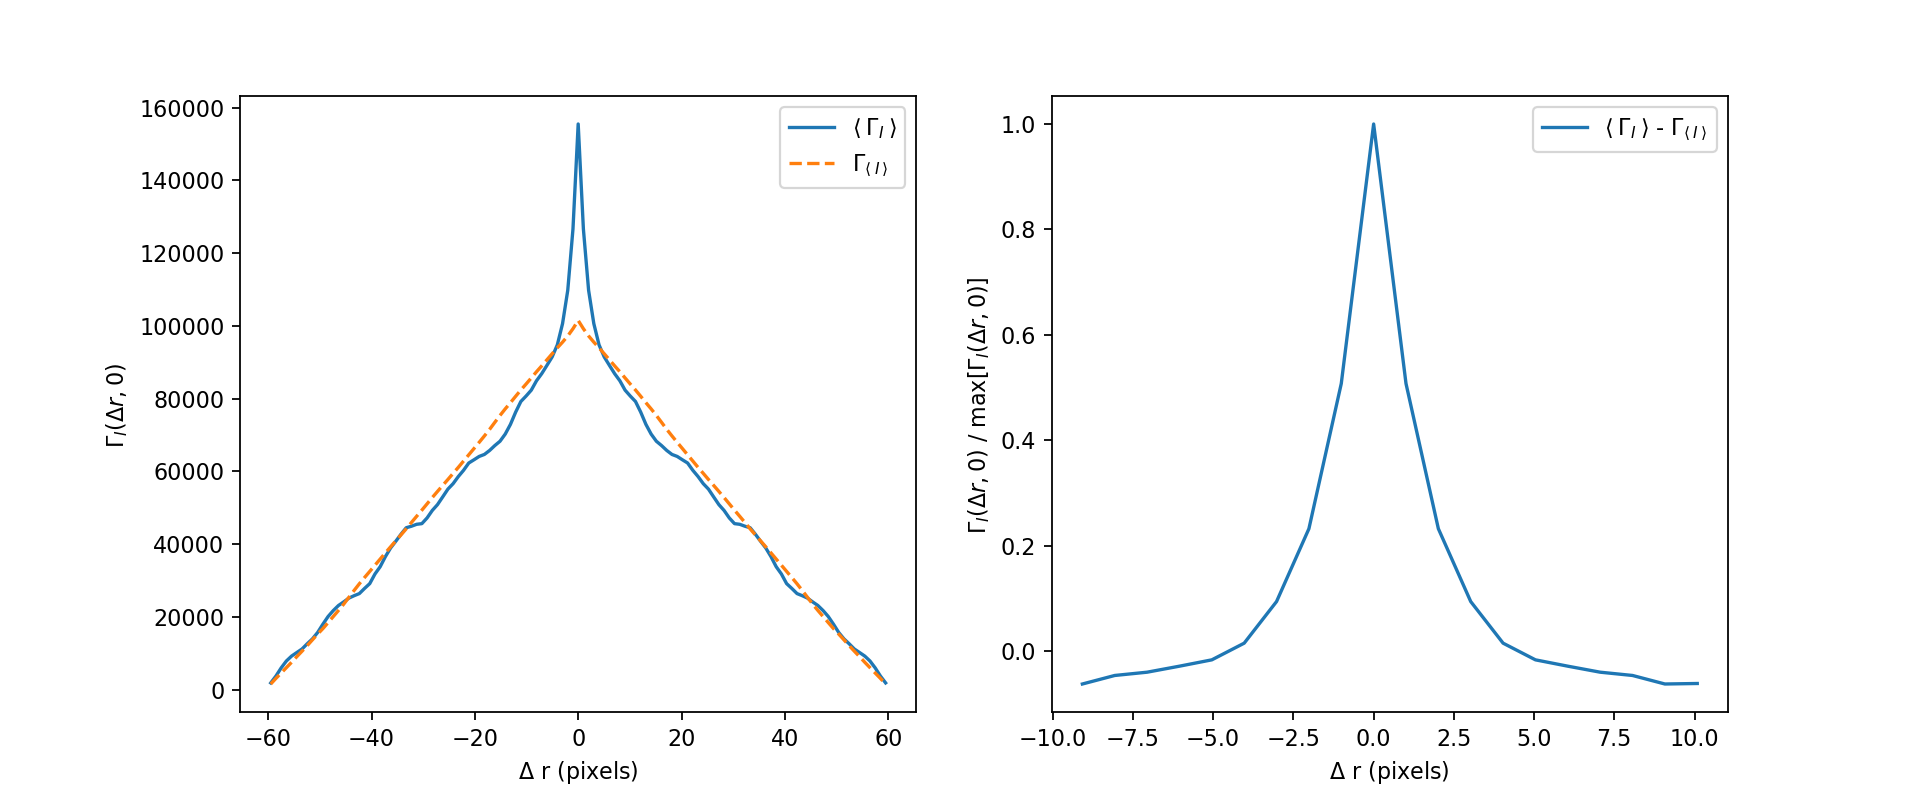

In [68]:
train = 11

fig, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)


ax1.plot(xaxis, n_od_corr[train][0], label=r'$\langle \:\Gamma_{I}\: \rangle$')
#ax1.plot(xaxis, 1.2*od_avg_corr[train], label=r'$\langle \:\Gamma_{I}\: \rangle$')
ax1.plot(xaxis, od_corr_avg_I[train], '--', label = r'$\Gamma_{\langle\: I\: \rangle}$')
    

ax2.plot(xaxis[50:70], subtracted_ycut_normalised[train][50:70] , label = r'$\langle \:\Gamma_{I}\: \rangle$ - $\Gamma_{\langle \: I \: \rangle}$') 
    
ax1.set_xlabel(r'$\Delta$ r (pixels)')
ax1.set_ylabel(r'$\Gamma_I(\Delta r, 0)$ ')
ax2.set_xlabel(r'$\Delta$ r (pixels)')
ax2.set_ylabel(r'$\Gamma_I(\Delta r, 0)$ / max[$\Gamma_I(\Delta r,0)$] ')

ax1.legend()
ax2.legend()

In [69]:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return np.exp( -0.5 * (x-mu)**2 / sigma**2)



def gauss_pdf_bkg(x, N, mu, sigma, bkg) :
    """Gaussian"""
    return (np.exp( -0.5 * (x-mu)**2 / sigma**2) + bkg)*N


In [70]:
init_vals = []
sigma_guess = np.append(np.linspace(0.2,1.7,int(Ntrains/2)), np.linspace(0.2,1.8,int(Ntrains/2))[::-1])
bkg_guess = np.linspace(0,0,int(Ntrains))[::-1]
    
for i in range(Ntrains):
    temp = [1, 0, sigma_guess[i], bkg_guess[i]]        # N, mu, sigma (changes), bkg
    init_vals.append(temp)

# list to save fit parameters
parameters = []

for i in range(Ntrains):
    p_temp, c_temp = curve_fit(gauss_pdf_bkg, xaxis[50:70], subtracted_ycut_normalised[i][50:70], p0=init_vals[i])
    parameters.append(p_temp)

In [46]:
init_vals[16]

[1, 0, 0.6333333333333332, 0.0]

<IPython.core.display.Javascript object>


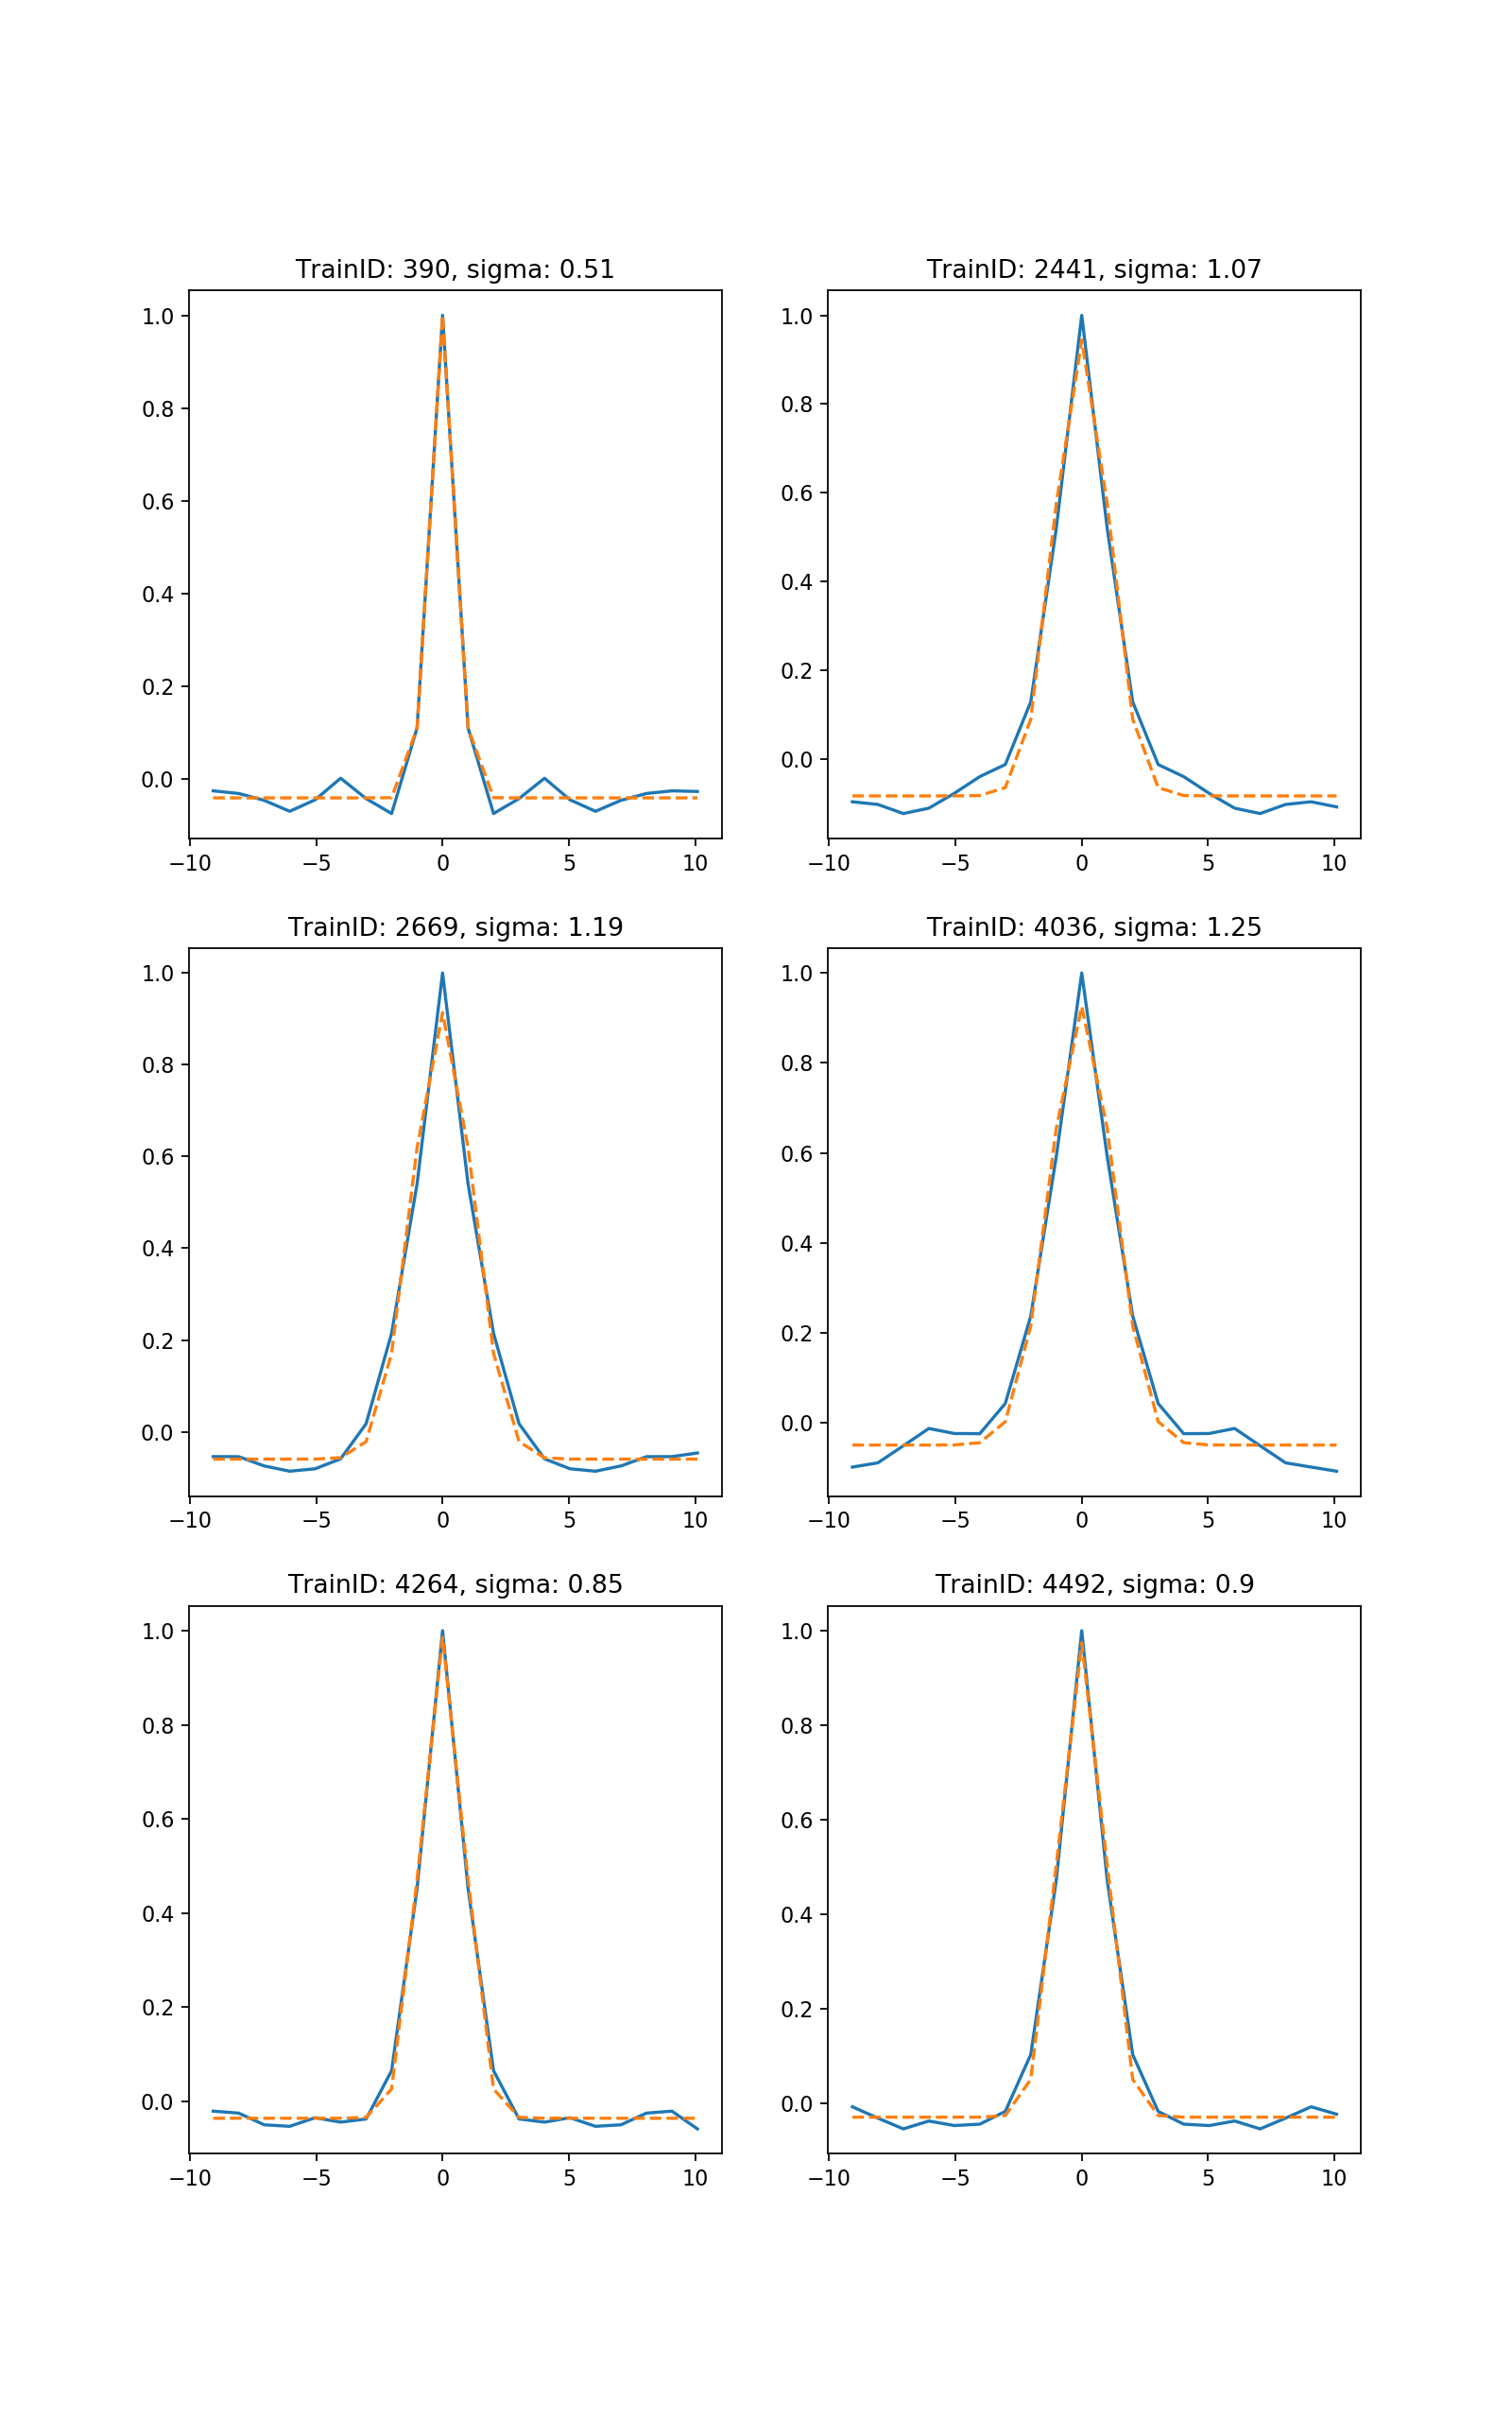

Text(0.5, 1.0, 'TrainID: 4492, sigma: 0.9')

In [73]:
fig, ((ax1, ax2), (ax3, ax4) , (ax5, ax6)) = plt.subplots(figsize=(10, 16), ncols=2, nrows=3)

inspect = [0, 9, 10, 16, 17, 18]

ax1.plot(xaxis[50:70], subtracted_ycut_normalised[inspect[0]][50:70], label = r'$\langle \:\Gamma_{I}\: \rangle$ - $\Gamma_{\langle \: I \: \rangle}$') 
ax1.plot(xaxis[50:70], gauss_pdf_bkg(xaxis[50:70],  parameters[inspect[0]][0], parameters[inspect[0]][1], parameters[inspect[0]][2], parameters[inspect[0]][3]), '--', label = r'$\Gamma_{\langle\: I\: \rangle}$')
ax1.set_title('TrainID: {}, sigma: {}'.format(trainIDs[inspect[0]], round(parameters[inspect[0]][2], 2)))

ax2.plot(xaxis[50:70], subtracted_ycut_normalised[inspect[1]][50:70], label = r'$\langle \:\Gamma_{I}\: \rangle$ - $\Gamma_{\langle \: I \: \rangle}$') 
ax2.plot(xaxis[50:70], gauss_pdf_bkg(xaxis[50:70],  parameters[inspect[1]][0], parameters[inspect[1]][1], parameters[inspect[1]][2], parameters[inspect[1]][3]), '--', label = r'$\Gamma_{\langle\: I\: \rangle}$')
ax2.set_title('TrainID: {}, sigma: {}'.format(trainIDs[inspect[1]], round(parameters[inspect[1]][2], 2)))

ax3.plot(xaxis[50:70], subtracted_ycut_normalised[inspect[2]][50:70], label = r'$\langle \:\Gamma_{I}\: \rangle$ - $\Gamma_{\langle \: I \: \rangle}$') 
ax3.plot(xaxis[50:70], gauss_pdf_bkg(xaxis[50:70],  parameters[inspect[2]][0], parameters[inspect[2]][1], parameters[inspect[2]][2], parameters[inspect[2]][3]), '--', label = r'$\Gamma_{\langle\: I\: \rangle}$')
ax3.set_title('TrainID: {}, sigma: {}'.format(trainIDs[inspect[2]], round(parameters[inspect[2]][2], 2)))
                                                  
ax4.plot(xaxis[50:70], subtracted_ycut_normalised[inspect[3]][50:70], label = r'$\langle \:\Gamma_{I}\: \rangle$ - $\Gamma_{\langle \: I \: \rangle}$') 
ax4.plot(xaxis[50:70], gauss_pdf_bkg(xaxis[50:70],  parameters[inspect[3]][0], parameters[inspect[3]][1], parameters[inspect[3]][2], parameters[inspect[3]][3]), '--', label = r'$\Gamma_{\langle\: I\: \rangle}$')
ax4.set_title('TrainID: {}, sigma: {}'.format(trainIDs[inspect[3]], round(parameters[inspect[3]][2], 2)))
                                                  
ax5.plot(xaxis[50:70], subtracted_ycut_normalised[inspect[4]][50:70], label = r'$\langle \:\Gamma_{I}\: \rangle$ - $\Gamma_{\langle \: I \: \rangle}$') 
ax5.plot(xaxis[50:70], gauss_pdf_bkg(xaxis[50:70],  parameters[inspect[4]][0], parameters[inspect[4]][1], parameters[inspect[4]][2], parameters[inspect[4]][3]), '--', label = r'$\Gamma_{\langle\: I\: \rangle}$')
ax5.set_title('TrainID: {}, sigma: {}'.format(trainIDs[inspect[4]], round(parameters[inspect[4]][2], 2)))
                                                  
ax6.plot(xaxis[50:70], subtracted_ycut_normalised[inspect[5]][50:70], label = r'$\langle \:\Gamma_{I}\: \rangle$ - $\Gamma_{\langle \: I \: \rangle}$') 
ax6.plot(xaxis[50:70], gauss_pdf_bkg(xaxis[50:70],  parameters[inspect[5]][0], parameters[inspect[5]][1], parameters[inspect[5]][2], parameters[inspect[5]][3]), '--', label = r'$\Gamma_{\langle\: I\: \rangle}$')
ax6.set_title('TrainID: {}, sigma: {}'.format(trainIDs[inspect[5]], round(parameters[inspect[5]][2], 2)))

In [196]:
sigma_fit = []
for i in range(len(parameters)):
    sigma_temp = parameters[i][2]/np.sqrt(2)
    sigma_fit.append(sigma_temp)
    
fwhm = 2.355*np.array(np.abs(sigma_fit))
specklesize = fwhm * 200 #microm

lotz = []
for i in tqdm(range(Ntrains)):
    t = arr_Lotz.values[trainIDs[i]]
    lotz.append(t)

100%|██████████| 30/30 [00:01<00:00, 15.79it/s]


<IPython.core.display.Javascript object>


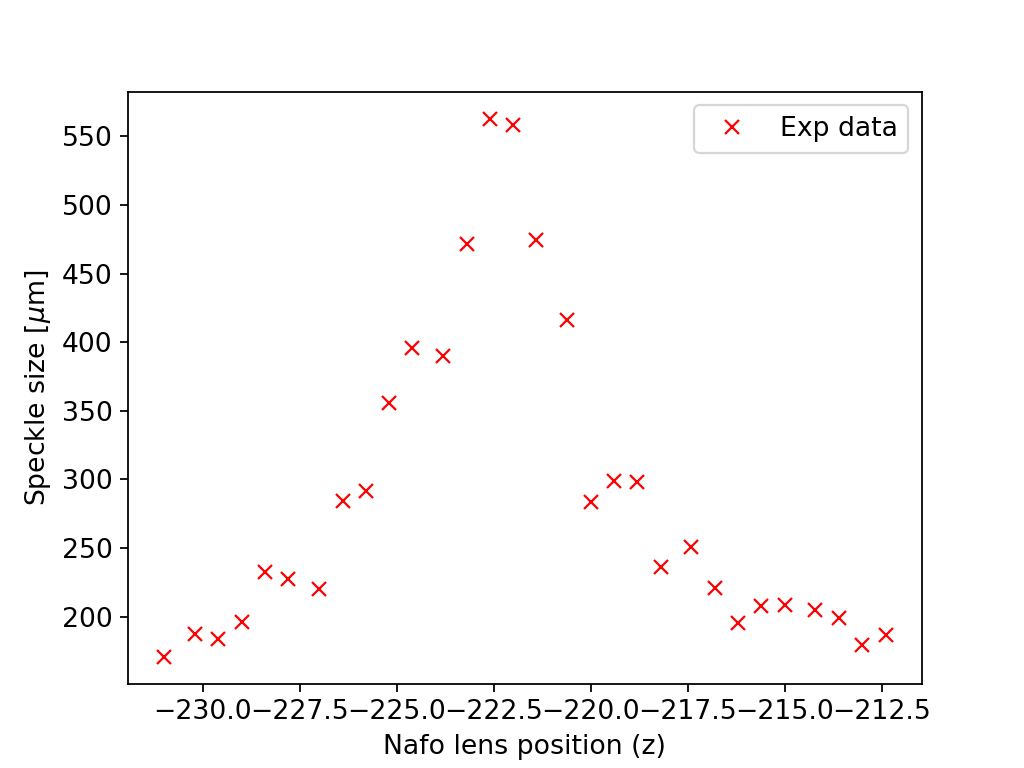

In [197]:
plt.figure(), plt.plot(lotz, specklesize, 'x', color='red', label='Exp data')
plt.xlabel(r'Nafo lens position (z)')
plt.ylabel(r'Speckle size [$\mu$m]')
plt.legend()

# Statistical fitting

In [198]:
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit
import sys    
from scipy import stats

sys.path.append('/External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [204]:
beamsize = 1 / specklesize
beamradius = beamsize

def spotsize(z, wo, zo, zr, b):
    s = np.sqrt(1 + ((z - zo)/zr)**2)
    return wo * s + b

init_vals = [3e-4 / 2, -2.22085910e+02,  0.93493284 /2, 0.0015 ]

In [205]:
chi2_object = Chi2Regression(spotsize, lotz, beamsize)
chi2_object.errordef = 1.0 

Npoints = len(beamsize)                       # Set number of data points len(array)
Nvar = 4                         # Set number of varying parameters
Ndof = Npoints - Nvar                # Find degrees of freedom

minuit = Minuit(chi2_object, wo = init_vals[0], zo = init_vals[1], zr = init_vals[2], b = init_vals[3])
minuit.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.669e-06                  │        Ncalls = 76 (76 total)        │
│ EDM = 1.8e-06 (Goal: 0.0002)     │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ wo   │   0.00    │   0.05    │            │            │         │         │       │
│ 1 │ zo   │  -0.2e3   │   0.4e3   │            │            │         │         │       │
│ 2 │ zr   │     0     │    90     │            │            │         │         │       │
│ 3 │ b    │    0.0    │    0.4    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [206]:
wo_fit, zo_fit, zr_fit, b_fit

(0.00015401067596812186,
 -222.1264754693236,
 0.26964163519527773,
 0.0010587534714252725)

<IPython.core.display.Javascript object>


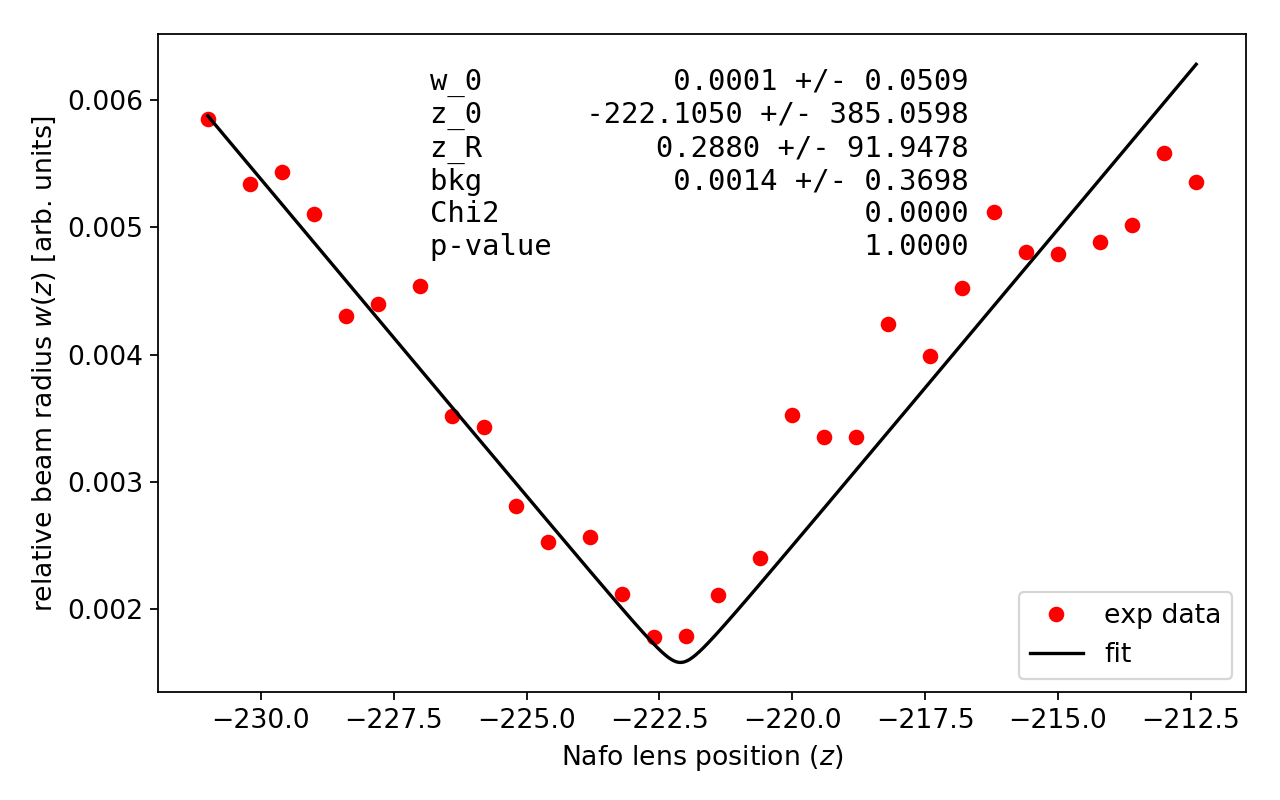

In [211]:
wo_fit, zo_fit, zr_fit, b_fit = minuit.values[:]
wo_err, zo_err, zr_err, b_err = minuit.errors[:]

plt.rcParams.update({'font.size': 12})

xtheo = np.linspace(np.min(lotz), np.max(lotz), 1000)
ytheo = spotsize(np.array(xtheo), wo_fit, zo_fit, zr_fit, b_fit) 

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots(figsize=(8, 5))  # figsize is in inches

fit = lambda x: spotsize(np.array(lotz), wo_fit, zo_fit, zr_fit, b_fit) 
ax.plot(lotz, beamsize, 'o', color='red', label='exp data')
ax.plot(xtheo, ytheo, '-', color="black", label='fit')
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_ylim([10**(-5), 10])
ax.set_xlabel(r'Nafo lens position $(z)$')
ax.set_ylabel(r'relative beam radius $w(z)$ [arb. units]')
ax.legend(loc='lower right')


d = {'w_0':[wo_fit, wo_err],
     'z_0': [zo_fit, zo_err],
     'z_R': [zr_fit, zr_err],
     'bkg': [b_fit, b_err],
     'Chi2':     Chi2_fit,
     'p-value': Prob_fit,
    }
text = nice_string_output(d, extra_spacing=2, decimals=4)
add_text_to_ax(0.25, 0.95, text, ax, fontsize=13)                  #Location of text:  63% Right, 95% Top 
fig.tight_layout()
plt.savefig('lotzplot.png')